## Synthetic statistics analysis : 

Objective : Analyze the effect of different parameters on the autocorrelation of synthetic signals

Method : 

1) High and low frequency signal are generated with 1 or several draws.

2) Each signal is filtered and demodulated.

3) The autocorrelation of the demodulated signals and their superposition is then computed.


In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

###  Signals generation

High frequency  parameters : 

$\omega_{M2} \simeq 1.9323$ cpd

$\omega_{S2} = 2$ cpd

$\omega \simeq 1.9662$ cpd


1) Varying amplitude, U_high

2) Varying decorrelation timescale, T

Low frequency parameters : 

1) fixed amplitude U=1

2) Varying decorrelation timescale, T_low

For high frequency : 

1) Monochromatic (M2 and S2)

2) Superposition (M2+S2 and M2+S2+N2+K2)

Total signal is computed is a result of the superposition of high and low frequency signals.

### Filtering and demodulation : 

High frequency (monochromatic and superpositions) and total signals are band pass filtered. Two varying parameters are used : 

1) Bandwidth, $d\omega$

2) Kernel length, $T_w$


The central frequency is : 

1) M2 or S2 for the monochromatic signals

2) (M2+S2)/2 for the superpositions (high frequency and total signals)

## Part 1 : High frequency signals random part varies with amplitude

In [2]:
#Load data
path = '/Users/zcaspar/codes/mit4320/' 
ds1 = xr.open_dataset(path+'synthetic_1_new.nc') #one draw
ds30 = xr.open_dataset(path+'synthetic_30_new.nc') #30 draws
#ds78 = xr.open_dataset(path+'synthetic_78.nc') # 78 draws

time = ds1.tau.values
print(time)

[0.00000000e+00 4.16666667e-02 8.33333333e-02 ... 4.99875000e+02
 4.99916667e+02 4.99958333e+02]


#### Impact of amplitude, decorrelation timescale, kernel length and bandwidth on monochromatic signal, M2

We can expect problems if : 

1) Inverse bandwidth is small compared to kernel length : $1/d\omega \leq T_w$

2) Inverse bandwidth is small compared to decorrelation timescale : $1/d\omega \leq T$

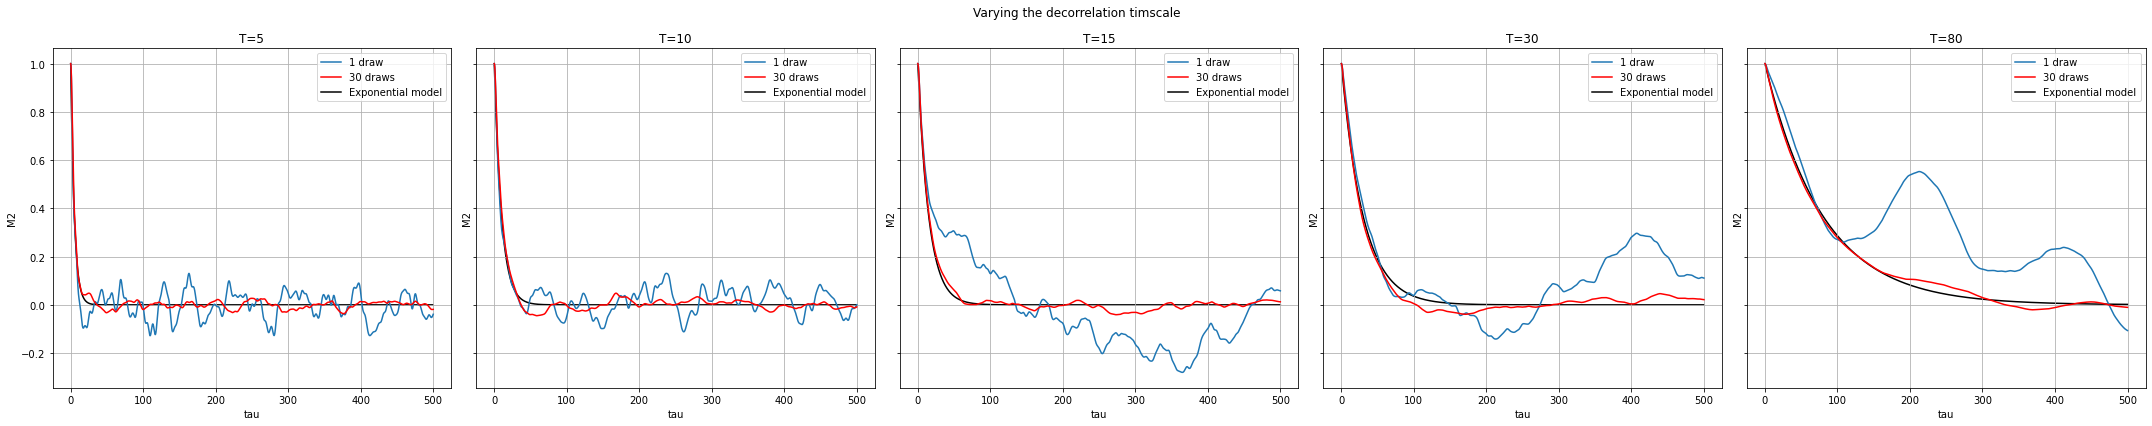

In [4]:
fig,ax = plt.subplots(1,ds1.T.size,figsize=(6*ds1.T.size,6),sharey=True)
for i,t in enumerate(ds1.T):
    (ds1.high_M2/ds1.high_M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t).plot(ax=ax[i],label='1 draw')
    (ds30.M2/ds30.M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t,T_low=15
                                     ).plot(ax=ax[i],label='30 draws',c='r')
    ax[i].plot(time,np.exp(-time/t.values),c='k',zorder=0,label='Exponential model')
    ax[i].set_title('T=%s'%t.values);ax[i].grid();ax[i].legend()
fig.suptitle('Varying the decorrelation timscale');
fig.tight_layout();

Notes on varying decorrelation timescale : 

Small oscillations are observed, superposed to the 'general' form. They are dampened when averaging over 30 draws.

Notes on varying amplitude, kernal length and bandwidth : 

1) Amplitude : modifies the form

2) Small changes between different bandwidth for $T_w=15days$

3) Small impact of kernel length on the impact of the bandwidth (but we are not in the case where $1/d\omega \leq T_w$)



<Figure size 432x288 with 0 Axes>

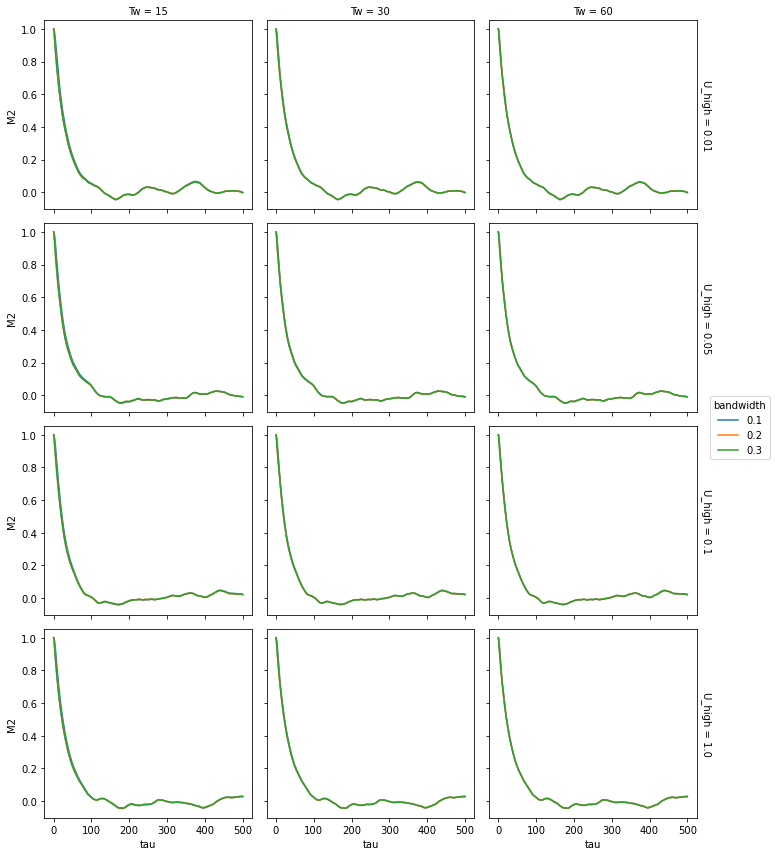

In [5]:
plt.figure()
(ds30.M2/ds30.M2.isel(tau=0)).sel(T=30,T_low=5).plot(hue='bandwidth',row='U_high',col='Tw')

Notes on averaging : 

1) Averaging remove the effects of bandwidth and kernel length.

2) Amplitude effect is also dampened

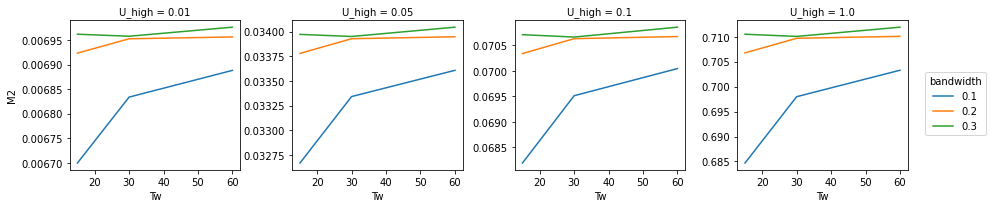

In [6]:
np.sqrt(ds30.M2.isel(tau=0).sel(T = 30,T_low=5)).plot(hue='bandwidth',col='U_high',sharey=False)

#### High frequency signal (M2+S2)

Notes on decorrelation timescale and amplitude : 

1) Spring neap cycle for $T \geq 15 days$

2) Negative lobe around 10 days for T=5,10 days

3) Amplitude modifies form for 1 draw; impact removed by averaging

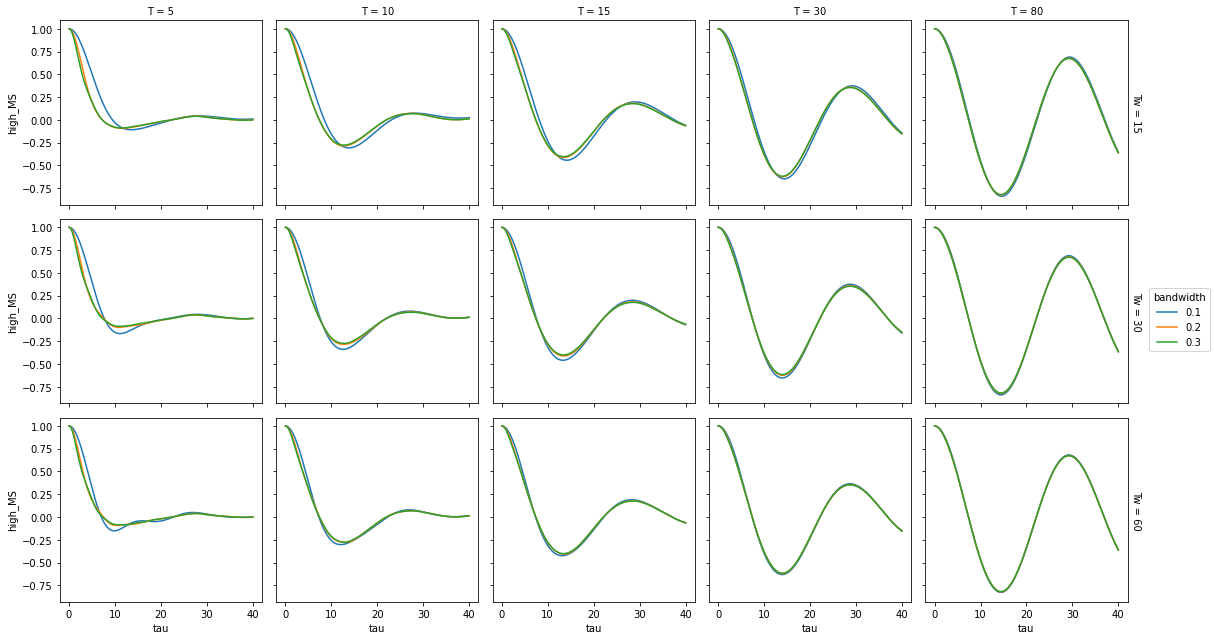

In [7]:
(ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=0.1,T_low=15).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

Notes : 

1) Averaging dampens oscillations for T=5 (as for monochromatic)

2) Variability due to bandwidth and kernel length

3) Negative lobe for T=10 days and for T=5days and $d\omega=0.1$

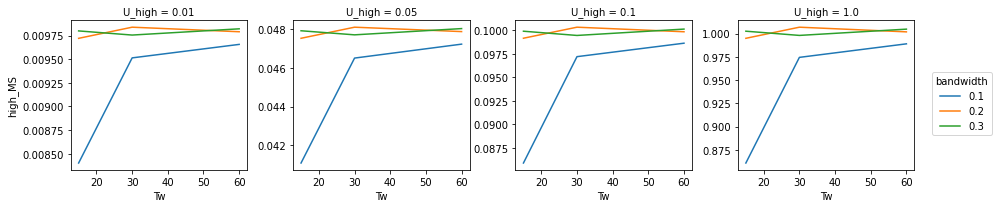

In [8]:
np.sqrt(ds30.high_MS.isel(tau=0).sel(T = 30,T_low=5)).plot(hue='bandwidth',col='U_high',sharey=False)

#### Low frequency

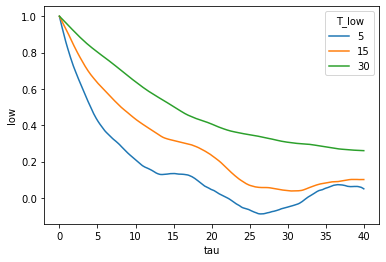

In [9]:
(ds1.low/ds1.low.isel(tau=0)).sel(tau=slice(0,40)).plot(hue='T_low')

#### Total

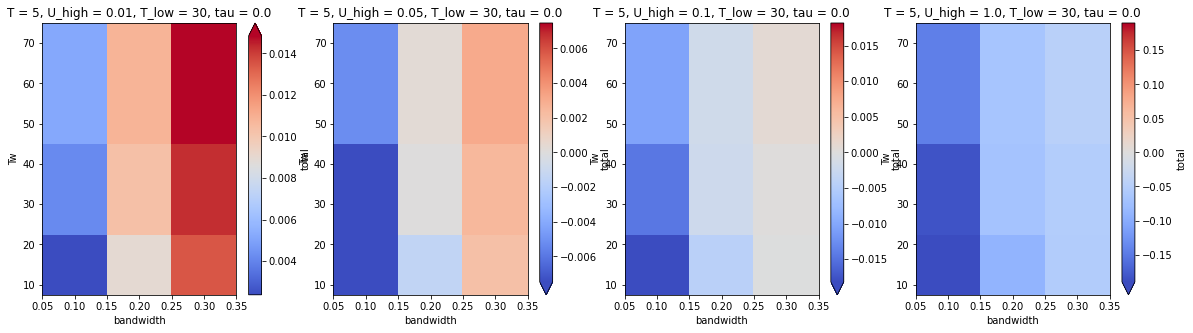

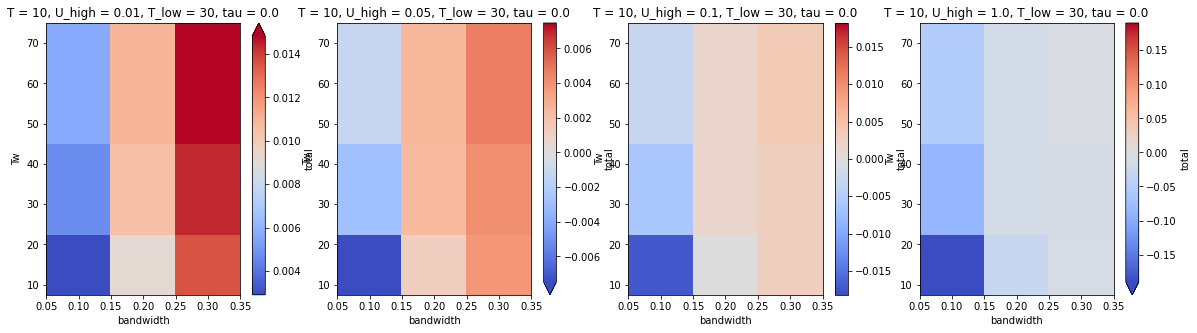

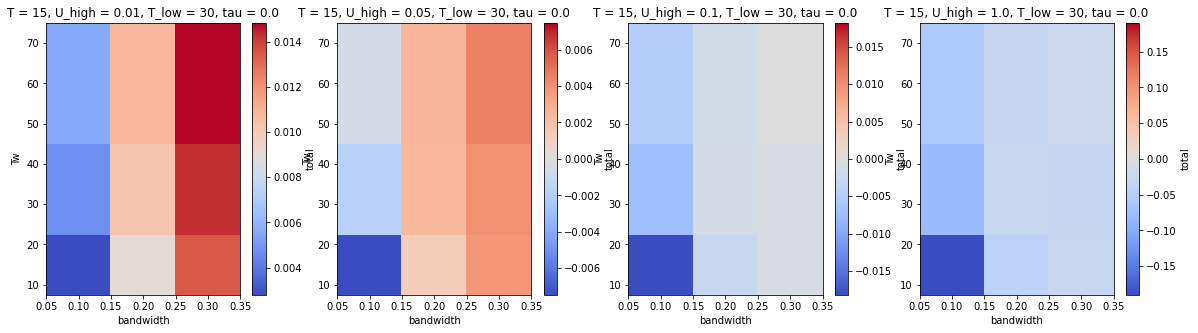

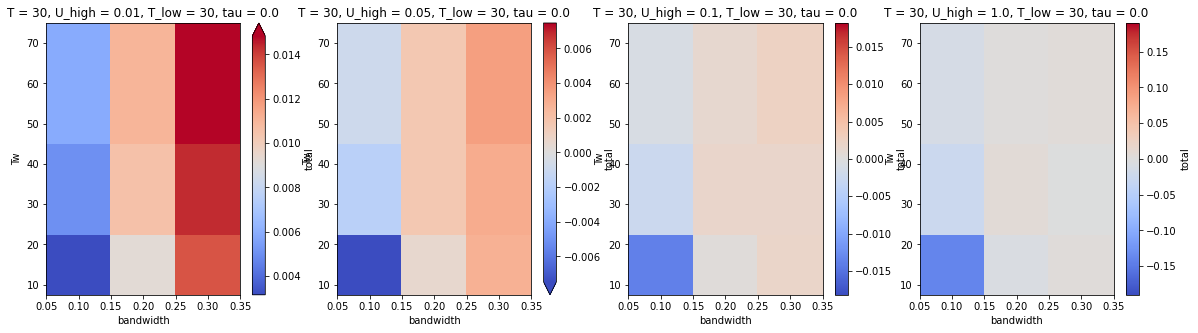

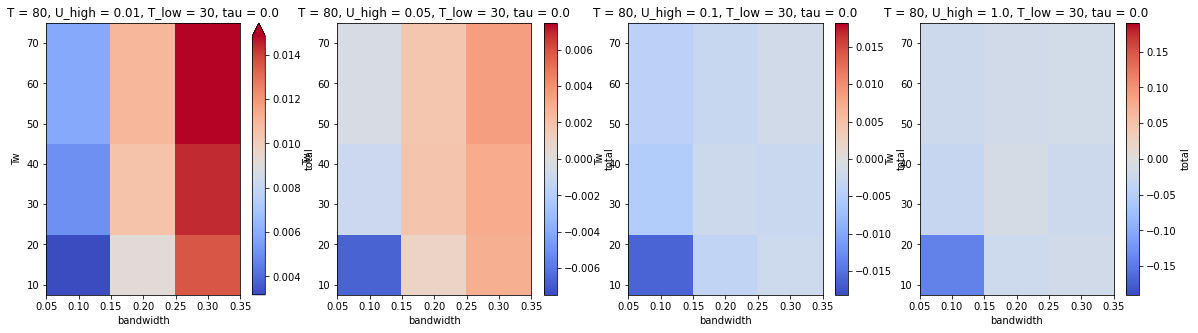

In [10]:
for t in ds30.T.values:
    fig,ax = plt.subplots(1,ds30.U_high.size,figsize=(5*ds30.U_high.size,5))
    for i,U in enumerate(ds30.U_high.values):
        vmax = max(np.abs(np.sqrt(ds30.total.isel(tau=0).sel(T_low=30,T=15,U_high=U))-U).max(),U/10)
        (np.sqrt(ds30.total.isel(tau=0).sel(T_low=30,T=t,U_high=U))-U).plot(x='bandwidth',y='Tw',ax=ax[i],cmap='coolwarm',vmax=vmax)
    #hue='bandwidth',col='U_high',row='T',sharey=False

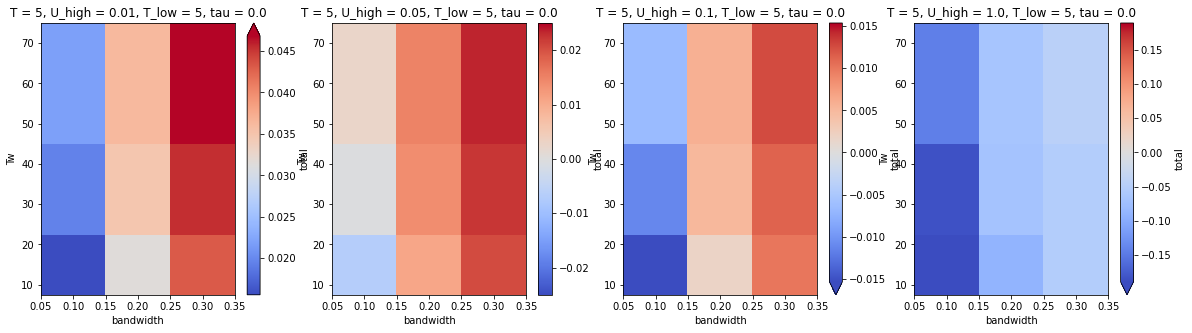

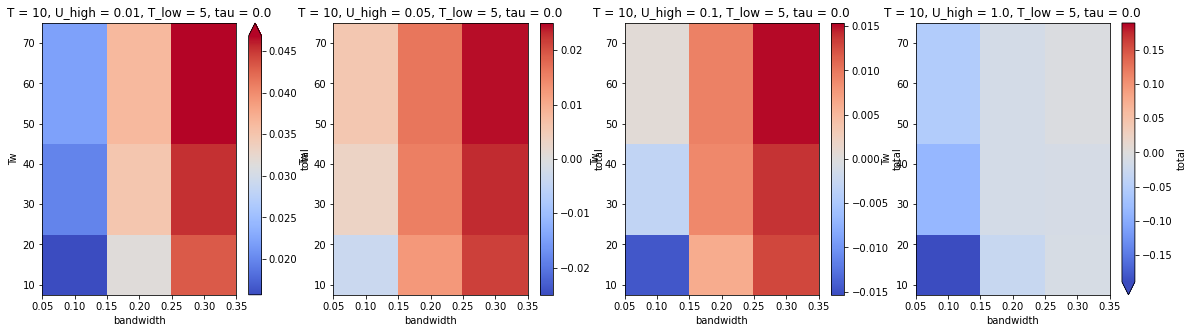

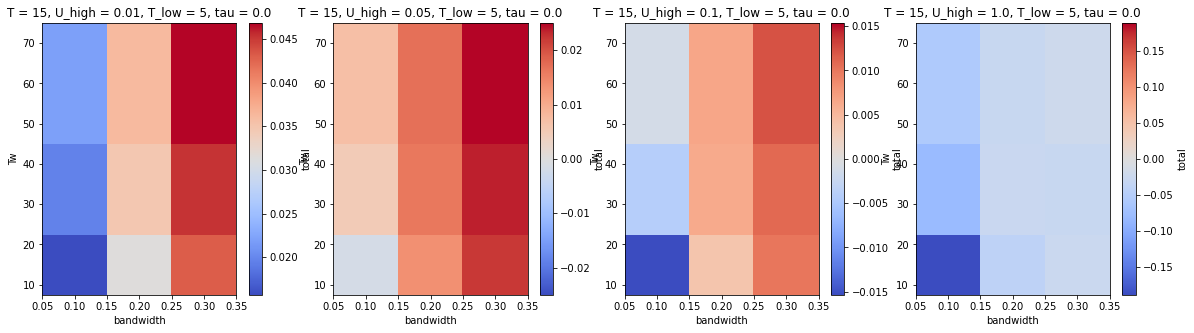

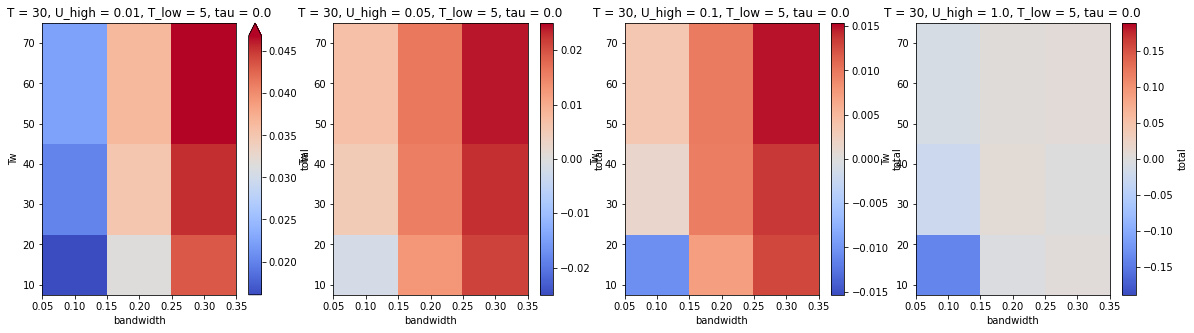

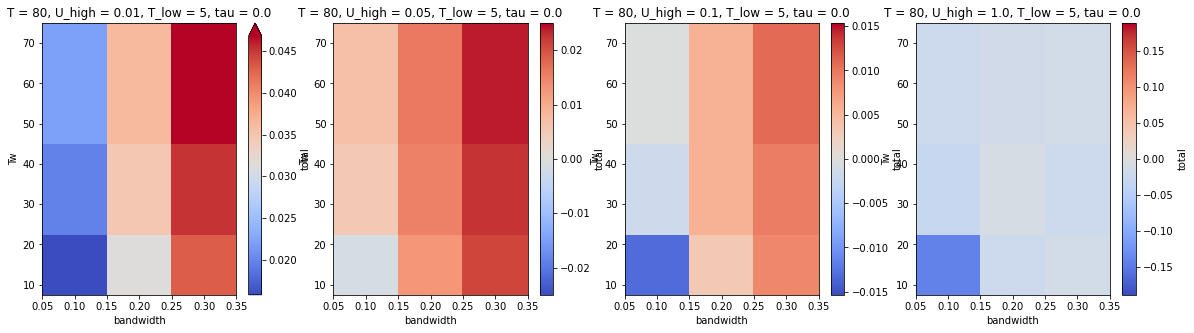

In [11]:
for t in ds30.T.values:
    fig,ax = plt.subplots(1,ds30.U_high.size,figsize=(5*ds30.U_high.size,5))
    for i,U in enumerate(ds30.U_high.values):
        vmax = max(np.abs(np.sqrt(ds30.total.isel(tau=0).sel(T_low=5,T=15,U_high=U))-U).max(),U/10)
        (np.sqrt(ds30.total.isel(tau=0).sel(T_low=5,T=t,U_high=U))-U).plot(x='bandwidth',y='Tw',ax=ax[i],cmap='coolwarm',vmax=vmax)

Text(0.5, 0.98, '30 draws : $\\tilde V = \\bar V = 1, d\\omega=0.4cpd,T_w=30d$')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


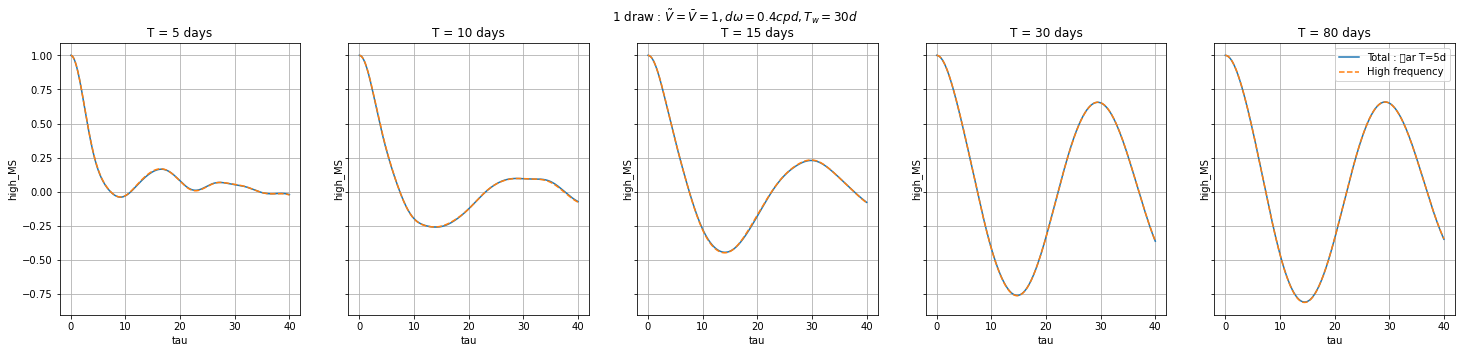

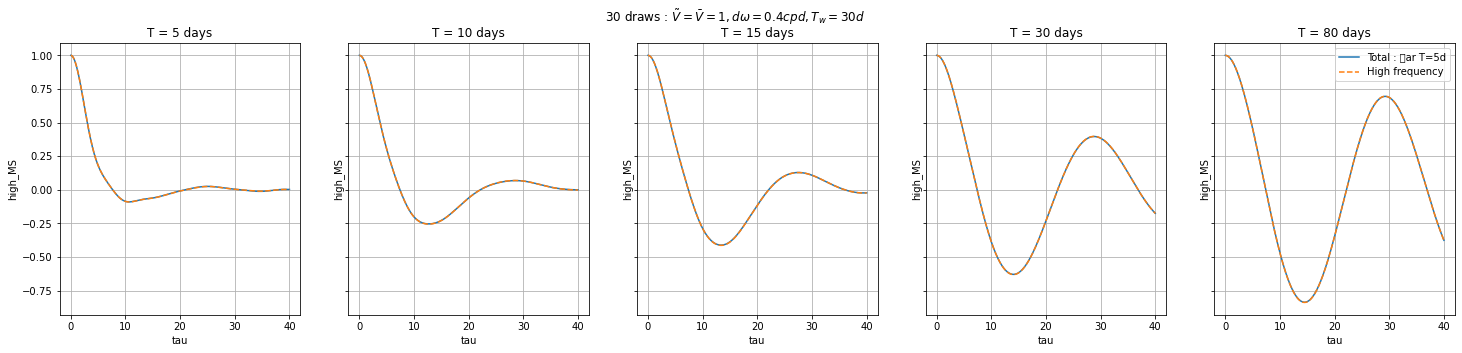

In [12]:
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=1.,T_low=5,Tw=30,bandwidth=0.2,T=t
                                         ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=5d')
    (ds1.high_MS/ds1.high_MS.isel(tau=0)).sel(U_high=1.,Tw=30,bandwidth=0.2,T=t
                                             ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'1 draw : $\tilde V = \bar V = 1, d\omega=0.4cpd,T_w=30d$')
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=1.,T_low=5,Tw=30,bandwidth=0.2,T=t
                                           ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=5d')
    (ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=1.,T_low=5,Tw=30,bandwidth=0.2,T=t
                                               ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'30 draws : $\tilde V = \bar V = 1, d\omega=0.4cpd,T_w=30d$')

Notes : 

If U_high = U, there is no differences between high frequency and total signal. No impact of the low singal on the final result.

#### U_high= U/10 and T_low=5days

Text(0.5, 0.98, '30 draws : $\\tilde V = \\bar V/10 = 0.1, d\\omega=0.4cpd,T_w=30d$')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


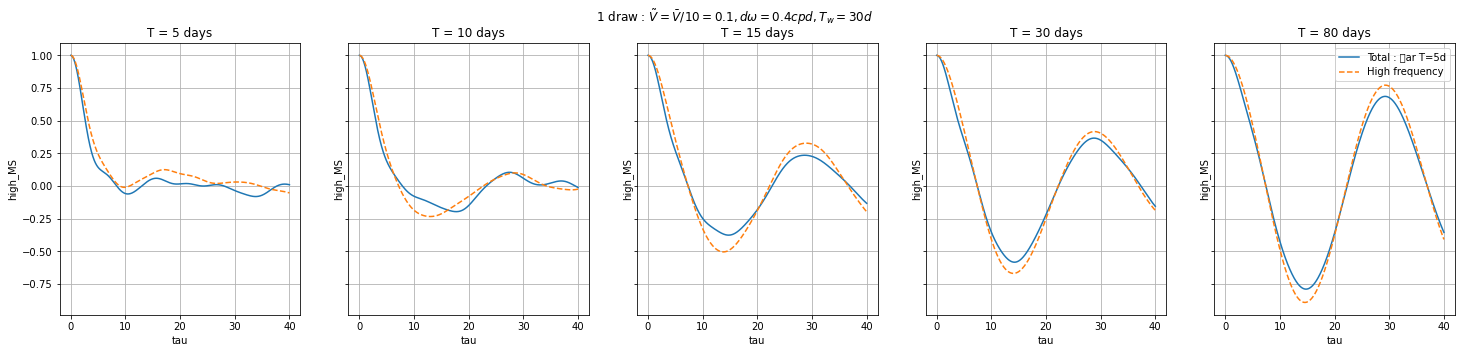

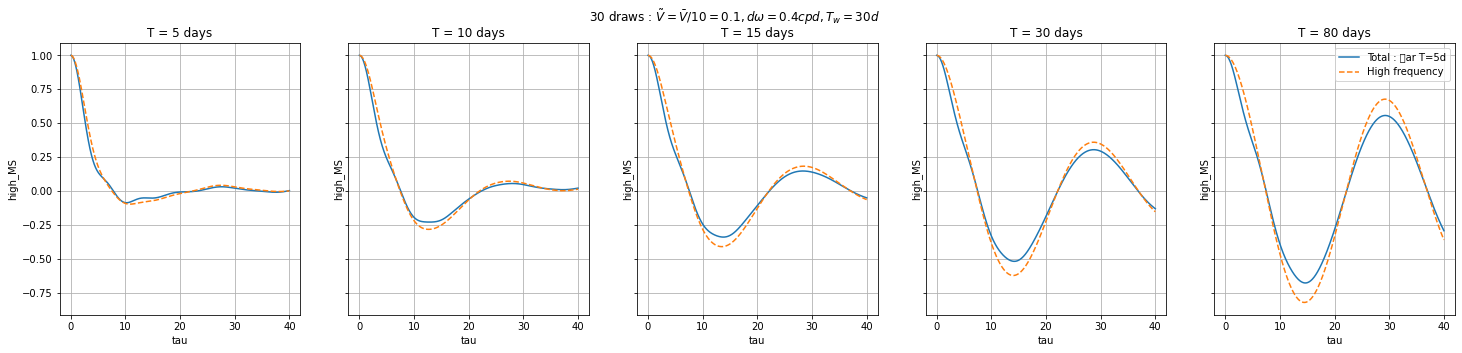

In [28]:
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=.1,T_low=5,Tw=30,bandwidth=0.2,T=t
                                         ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=5d')

    (ds1.high_MS/ds1.high_MS.isel(tau=0)).sel(U_high=.1,Tw=30,bandwidth=0.2,T=t
                                             ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'1 draw : $\tilde V = \bar V/10 = 0.1, d\omega=0.4cpd,T_w=30d$')
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=.1,T_low=5,Tw=30,bandwidth=0.2,T=t
                                           ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=5d')
    (ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=.1,T_low=5,Tw=30,bandwidth=0.2,T=t
                                               ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'30 draws : $\tilde V = \bar V/10 = 0.1, d\omega=0.4cpd,T_w=30d$')

Notes : 

1) Larger impact of bandwidth for all values of T

2) $d\omega$=0.2 cpd has very smooth results (leakage??)

3) Small oscillations increases when T decreases and bandwidth increases.

Notes : 

1) Averaging dampens small oscillations but still there for $d\omega$=0.6 cpd

2) Negative lobe still there for T=5,10 days ; increased for $d\omega$=0.2 cpd

#### U_high= U/10 and T_low=30days

Text(0.5, 0.98, '30 draws : $\\tilde V = \\bar V/10 = 0.1, d\\omega=0.4cpd,T_w=30d$')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


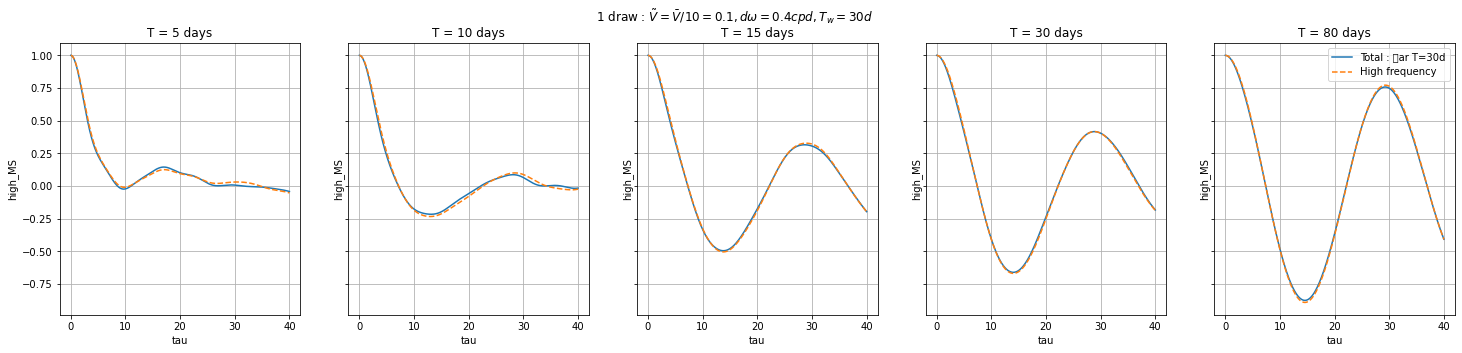

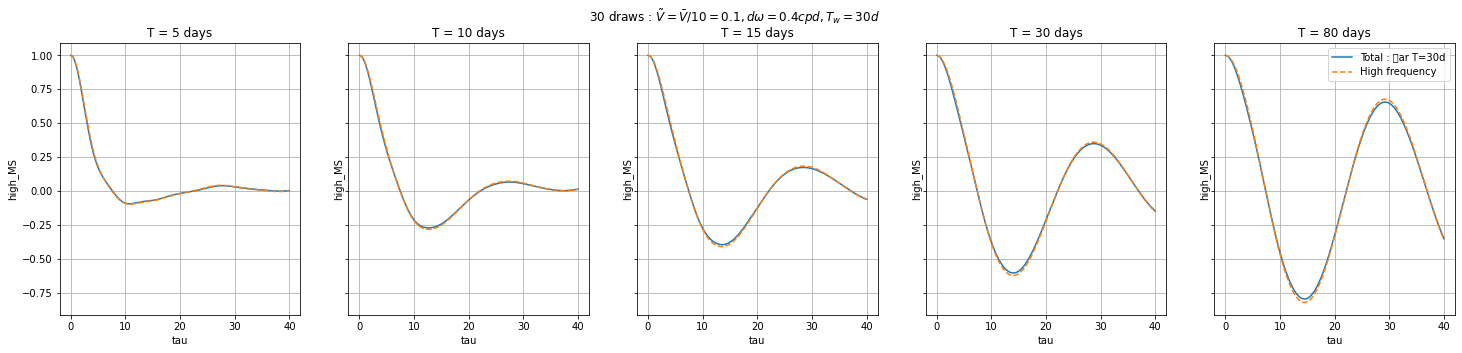

In [26]:
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=.1,T_low=30,Tw=30,bandwidth=0.2,T=t
                                         ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=30d')

    (ds1.high_MS/ds1.high_MS.isel(tau=0)).sel(U_high=.1,Tw=30,bandwidth=0.2,T=t
                                             ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'1 draw : $\tilde V = \bar V/10 = 0.1, d\omega=0.4cpd, T_w=30d$')
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=.1,T_low=30,Tw=30,bandwidth=0.2,T=t
                                           ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=30d')

    (ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=.1,T_low=30,Tw=30,bandwidth=0.2,T=t
                                               ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'30 draws : $\tilde V = \bar V/10 = 0.1, d\omega=0.4cpd,T_w=30d$')

Notes : Small differences between total and high frequency signal but overall it is similar (very similar for the average).

#### U_high=U/100 and T_low=5 days

Text(0.5, 0.98, '30 draws : $\\tilde V = \\bar V/100 = 0.01, d\\omega=0.4cpd,T_w=30d$')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


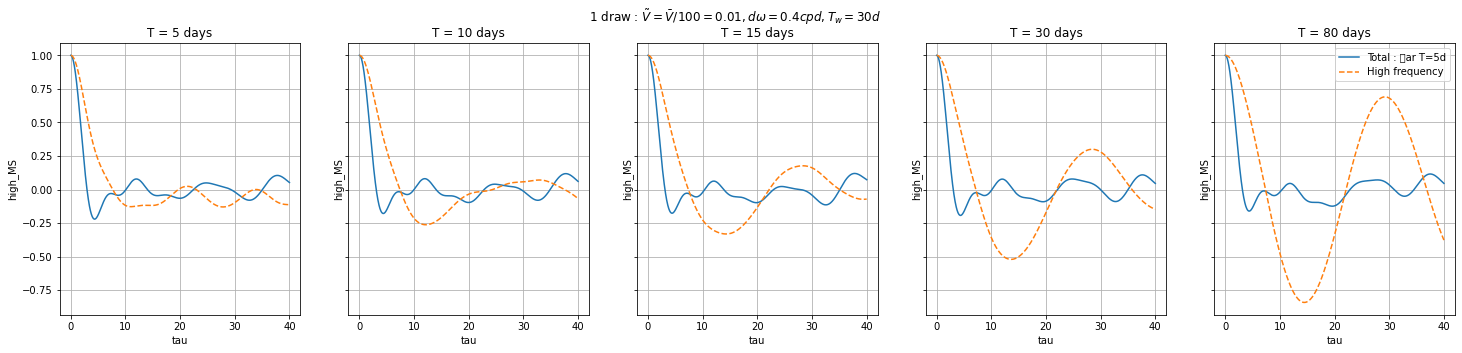

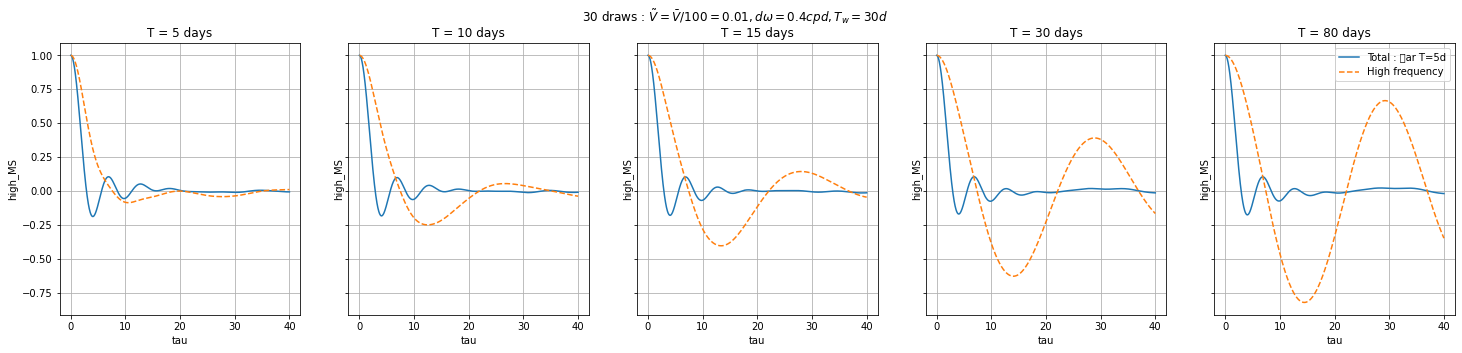

In [27]:
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=.01,T_low=5,Tw=30,bandwidth=0.2,T=t
                                         ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=5d')

    (ds1.high_MS/ds1.high_MS.isel(tau=0)).sel(U_high=.01,Tw=30,bandwidth=0.2,T=t
                                             ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'1 draw : $\tilde V = \bar V/100 = 0.01, d\omega=0.4cpd,T_w=30d$')
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=.01,T_low=5,Tw=30,bandwidth=0.2,T=t
                                           ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=5d')

    (ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=.01,T_low=5,Tw=30,bandwidth=0.2,T=t
                                               ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'30 draws : $\tilde V = \bar V/100 = 0.01, d\omega=0.4cpd,T_w=30d$')

Text(0.5, 0.98, '30 draws : $\\tilde V = \\bar V/100 = 0.01, d\\omega=0.2cpd,T_w=30d$')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


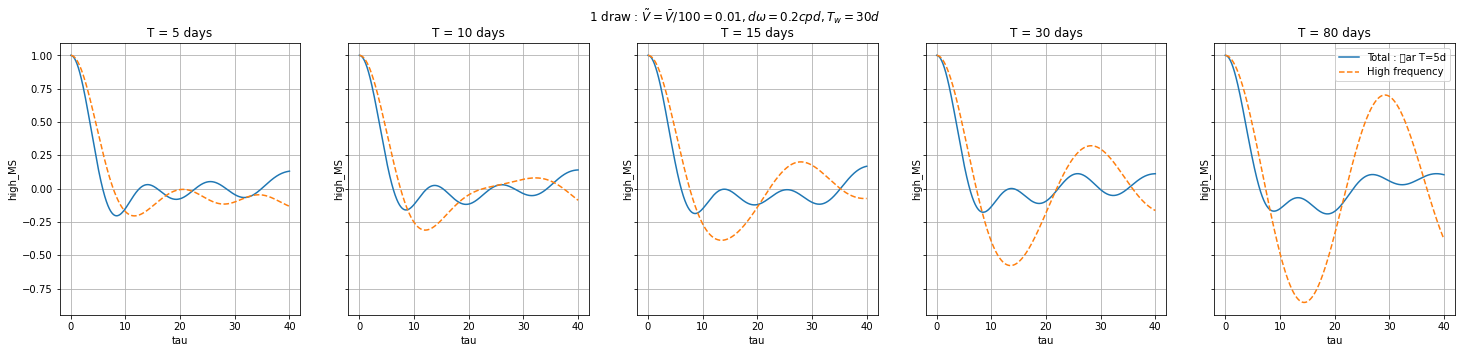

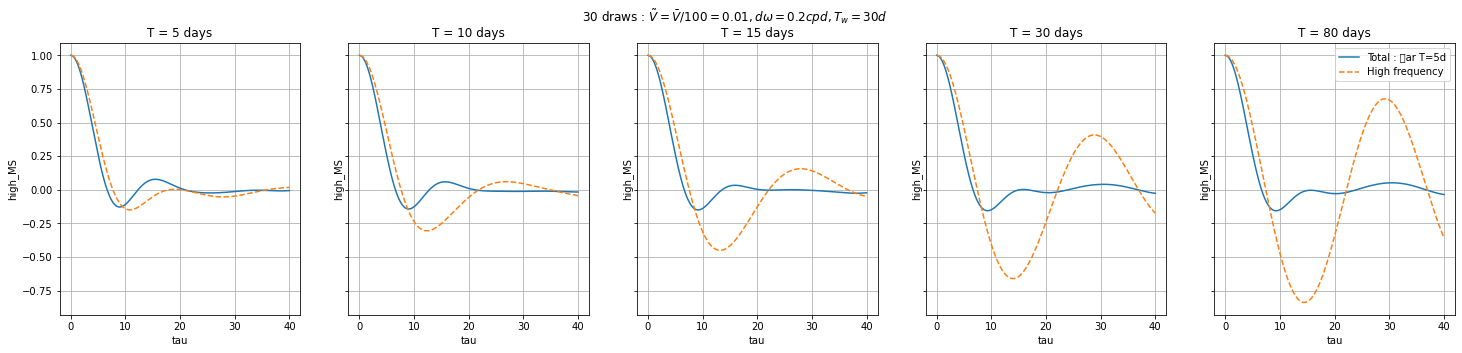

In [34]:
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=.01,T_low=5,Tw=30,bandwidth=0.1,T=t
                                         ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=5d')

    (ds1.high_MS/ds1.high_MS.isel(tau=0)).sel(U_high=.01,Tw=30,bandwidth=0.1,T=t
                                             ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'1 draw : $\tilde V = \bar V/100 = 0.01, d\omega=0.2cpd,T_w=30d$')
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=.01,T_low=5,Tw=30,bandwidth=0.1,T=t
                                           ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=5d')

    (ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=.01,T_low=5,Tw=30,bandwidth=0.1,T=t
                                               ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'30 draws : $\tilde V = \bar V/100 = 0.01, d\omega=0.2cpd,T_w=30d$')

Notes : 

1) No spring neap cycle

2) Small oscillations for all values of T

3) Effect of the kernel length

4) $d\omega=0.1$ still a lot smoother

Notes : 

This time averaging does not dampen the oscillations, in the contrary they seem more robust.

Oscillations are more robuts depending on tau when the kernel length increases.

Still no spring neap cycle

#### U_high=U/100 and T_low = 30d

Text(0.5, 0.98, '30 draws : $\\tilde V = \\bar V/100 = 0.01, d\\omega=0.4cpd,T_w=30d$')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


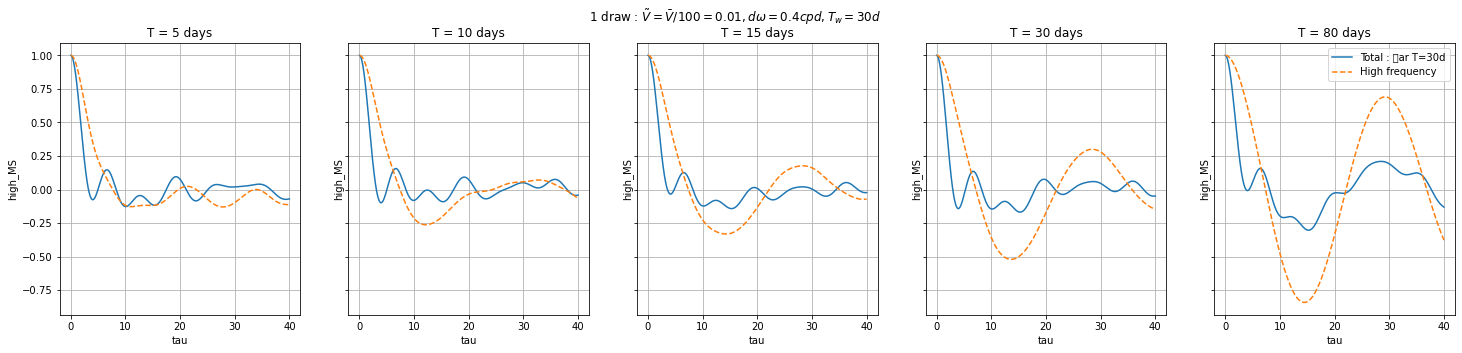

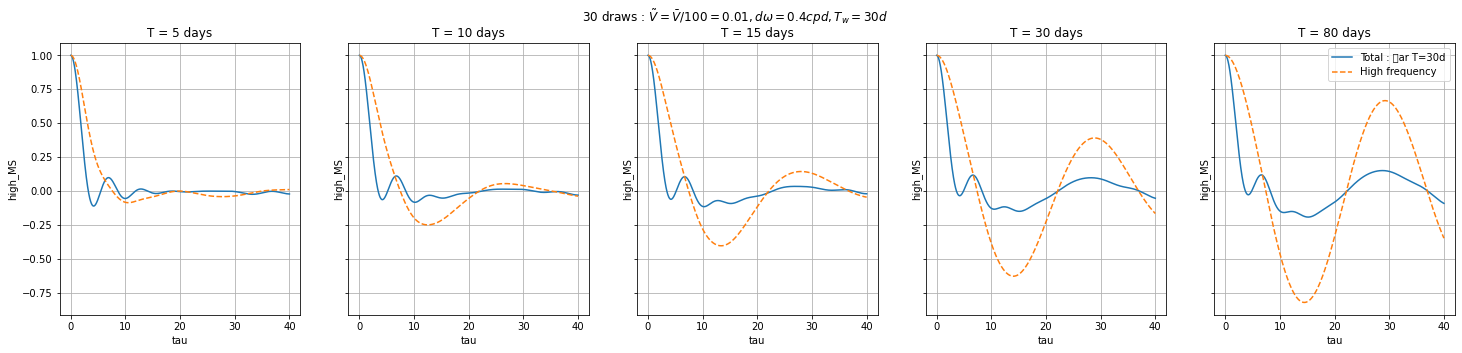

In [31]:
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=.01,T_low=30,Tw=30,bandwidth=0.2,T=t
                                         ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=30d')

    (ds1.high_MS/ds1.high_MS.isel(tau=0)).sel(U_high=.01,Tw=30,bandwidth=0.2,T=t
                                             ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'1 draw : $\tilde V = \bar V/100 = 0.01, d\omega=0.4cpd, T_w=30d$')
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=.01,T_low=30,Tw=30,bandwidth=0.2,T=t
                                           ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=30d')

    (ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=.01,T_low=30,Tw=30,bandwidth=0.2,T=t
                                               ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'30 draws : $\tilde V = \bar V/100 = 0.01, d\omega=0.4cpd,T_w=30d$')

Notes : 

1) Spring neap cycle for $T\geq 30 days$

2) Small oscillations for $d\omega=0.4,0.6$

Text(0.5, 0.98, '30 draws : $\\tilde V = \\bar V/100 = 0.01, d\\omega=0.2cpd,T_w=30d$')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


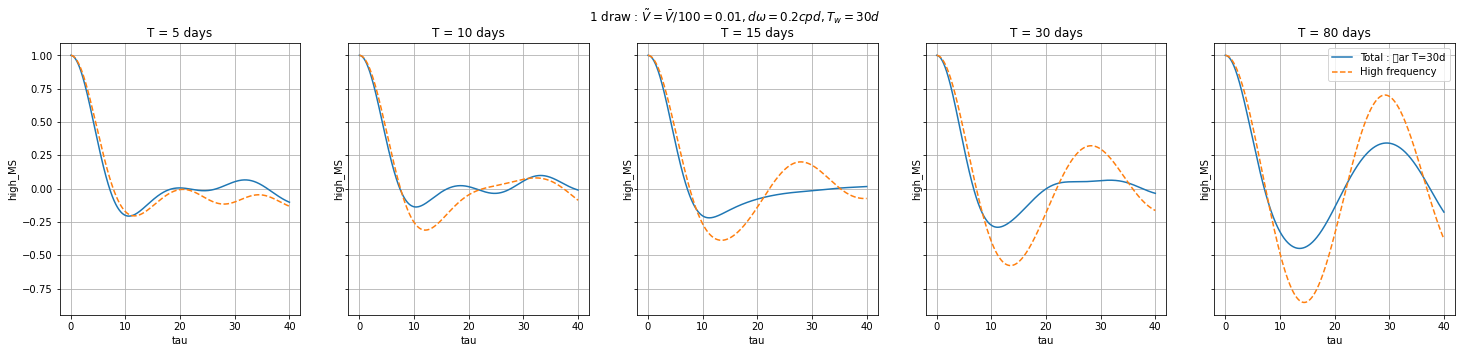

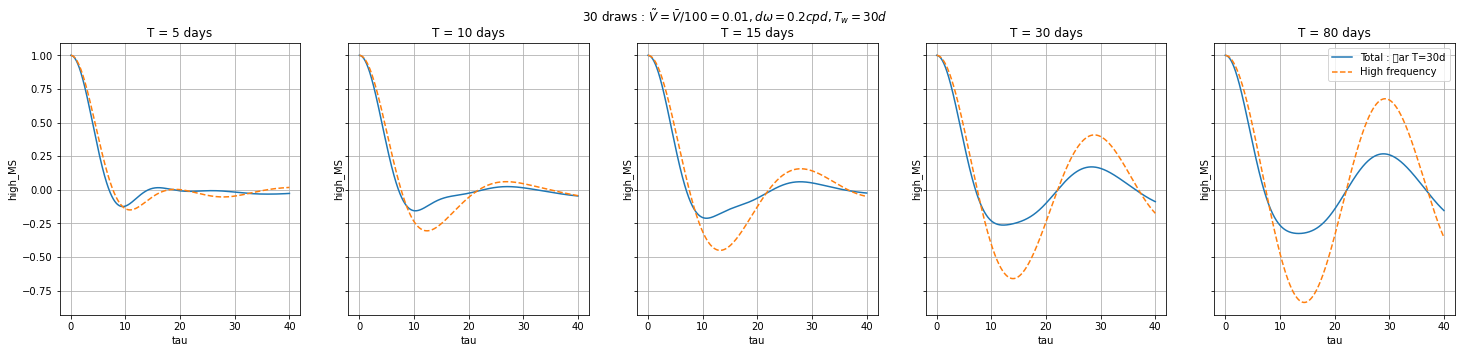

In [33]:
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=.01,T_low=30,Tw=30,bandwidth=0.1,T=t
                                         ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=30d')

    (ds1.high_MS/ds1.high_MS.isel(tau=0)).sel(U_high=.01,Tw=30,bandwidth=0.1,T=t
                                             ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'1 draw : $\tilde V = \bar V/100 = 0.01, d\omega=0.2cpd, T_w=30d$')
fig,ax = plt.subplots(1,5,figsize=(25,5),sharey=True)
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=.01,T_low=30,Tw=30,bandwidth=0.1,T=t
                                           ).sel(tau=slice(0,40)).plot(ax=ax[i],label='Total : \bar T=30d')

    (ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=.01,T_low=30,Tw=30,bandwidth=0.1,T=t
                                               ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
    ax[i].set_title('T = %s days'%t.values);ax[i].grid()
ax[i].legend()
fig.suptitle(r'30 draws : $\tilde V = \bar V/100 = 0.01, d\omega=0.2cpd,T_w=30d$')

## Part 2 : High frequency signals different amplitudes obtained from one random signal (then multiplying by values of U_high)

In [55]:
#Load data
path = '/Users/zcaspar/codes/mit4320/' 
#ds1 = xr.open_dataset(path+'synthetic_1_U.nc') #one draw
#ds30 = xr.open_dataset(path+'synthetic_30_U.nc') #30 draws

#ds1_80 = xr.open_dataset(path+'synthetic_1_U_80d.nc') #one draw
#ds30_80 = xr.open_dataset(path+'synthetic_30_U_80d.nc') #30 draws

ds1 = xr.open_dataset(path+'synthetic_1_U.nc') #one draw
ds30 = xr.open_dataset(path+'synthetic_30_U_valid.nc') #30 draws

ds30_coh = xr.open_dataset(path+'synthetic_30_valid.nc') #30 draws
#ds1_80 = xr.open_dataset(path+'synthetic_1_U_80d.nc') #one draw
ds30_80 = xr.open_dataset(path+'synthetic_30_U_valid_80.nc') #30 draws

time = ds1.tau.values
time_80 = ds1_80.tau.values
print(time)

[0.00000000e+00 4.16666667e-02 8.33333333e-02 ... 4.99875000e+02
 4.99916667e+02 4.99958333e+02]


In [56]:
ds30 = ds30.assign_coords({'bandwidth':[d*2 for d in ds30.bandwidth]})

In [59]:
ds30 = ds30.sel(T=[5,15,30,80])
ds30_80 = ds30_80.sel(T=[5,15,30,80])
ds1 = ds1.sel(T=[5,15,30,80])

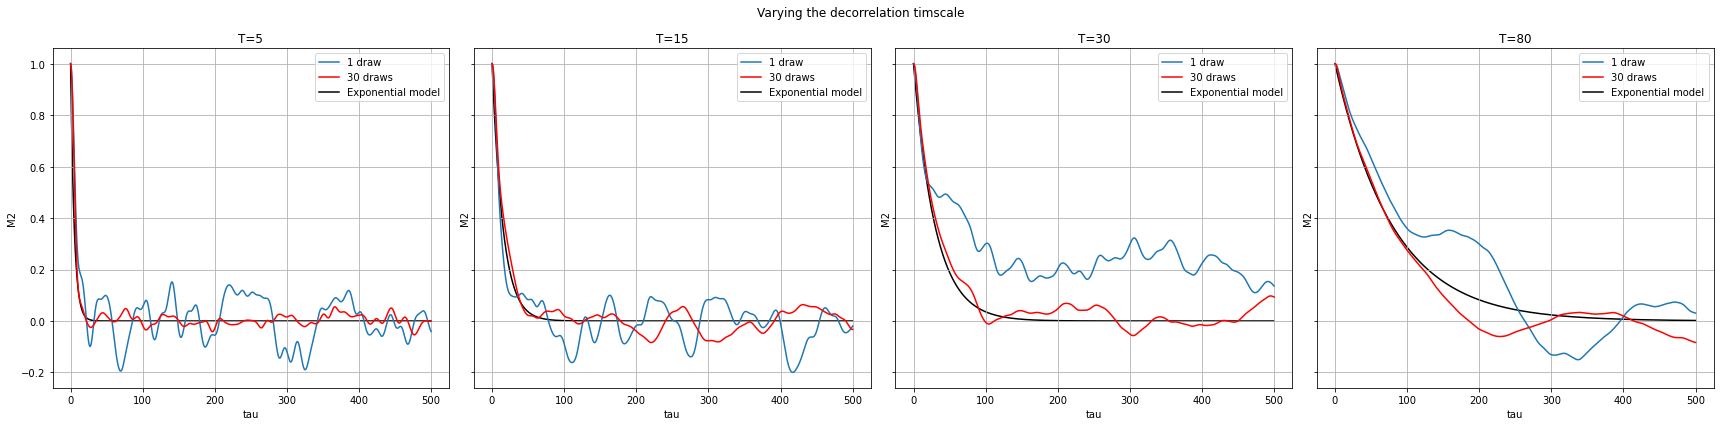

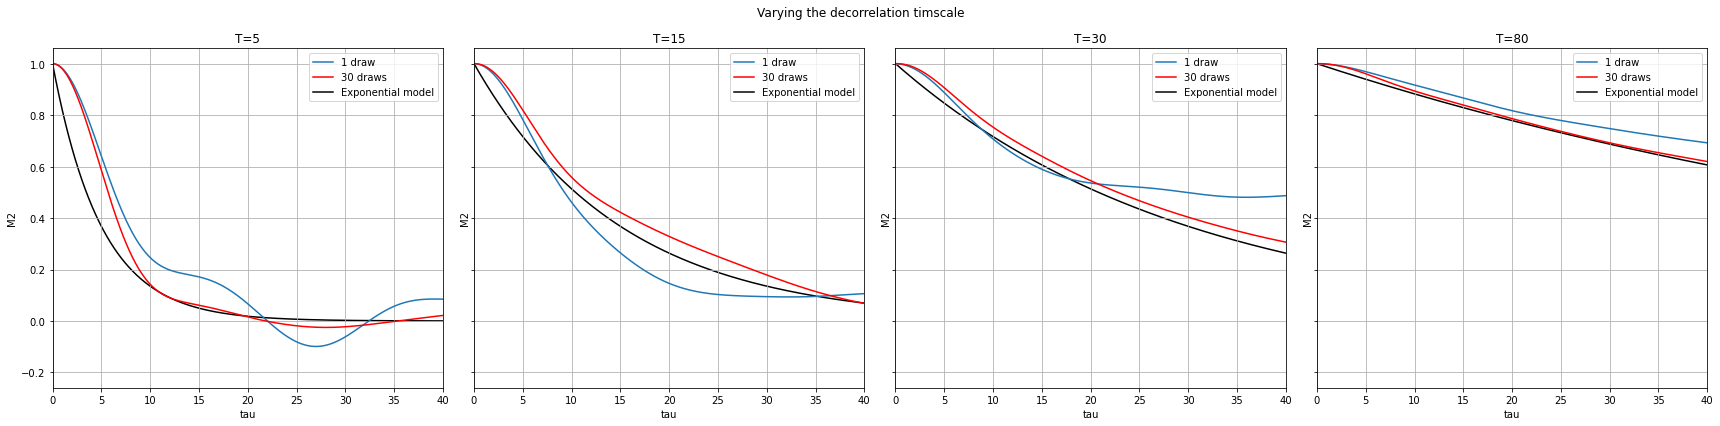

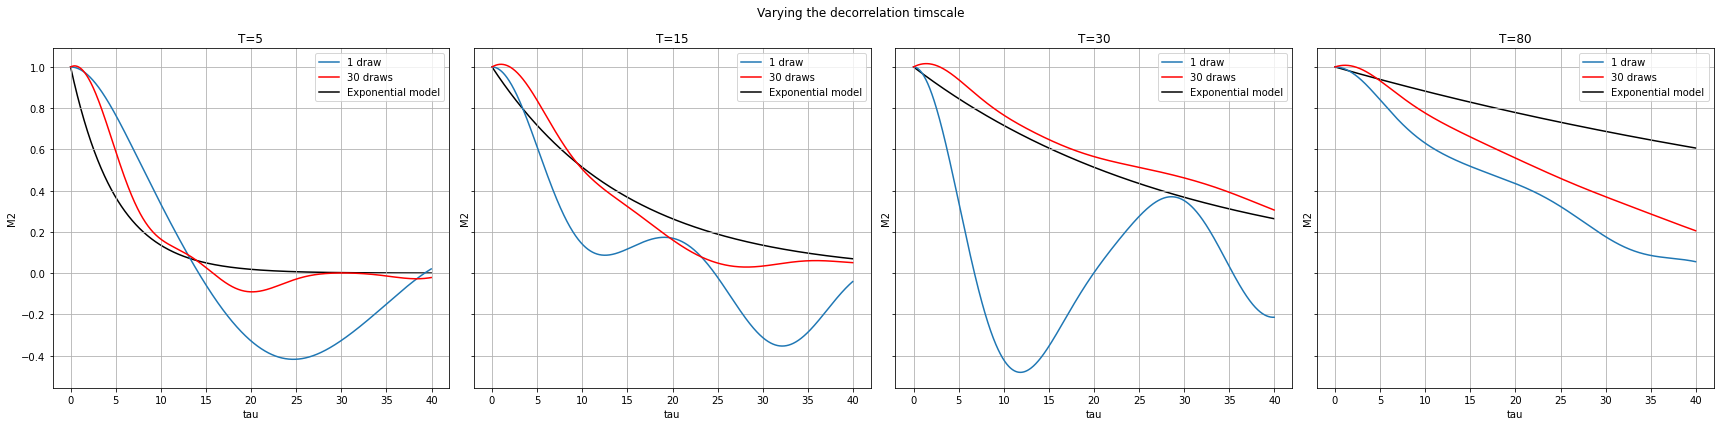

In [64]:
fig,ax = plt.subplots(1,ds1.T.size,figsize=(6*(ds1.T.size),6),sharey=True)
for i,t in enumerate(ds1.T):
    (ds1.high_M2/ds1.high_M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t).plot(ax=ax[i],label='1 draw')
    (ds30.M2/ds30.M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t,T_low=30
                                     ).plot(ax=ax[i],label='30 draws',c='r')
    ax[i].plot(time,np.exp(-time/t.values),c='k',zorder=0,label='Exponential model')
    ax[i].set_title('T=%s'%t.values);ax[i].grid();ax[i].legend()
fig.suptitle('Varying the decorrelation timscale');
fig.tight_layout();

fig,ax = plt.subplots(1,ds1.T.size,figsize=(6*(ds1.T.size),6),sharey=True)
for i,t in enumerate(ds1.T):
    (ds1.high_M2/ds1.high_M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t).plot(ax=ax[i],label='1 draw',xlim=(0,40))
    (ds30.M2/ds30.M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t,T_low=30
                                     ).plot(ax=ax[i],label='30 draws',c='r',xlim=(0,40))
    ax[i].plot(time_80,np.exp(-time_80/t.values),c='k',zorder=0,label='Exponential model')
    ax[i].set_title('T=%s'%t.values);ax[i].grid();ax[i].legend()
fig.suptitle('Varying the decorrelation timscale');
fig.tight_layout();

fig,ax = plt.subplots(1,ds1.T.size,figsize=(6*(ds1.T.size),6),sharey=True)
for i,t in enumerate(ds1.T):
    (ds1_80.high_M2/ds1_80.high_M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t).plot(ax=ax[i],label='1 draw')
    (ds30_80.M2/ds30_80.M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t,T_low=30
                                     ).plot(ax=ax[i],label='30 draws',c='r')
    ax[i].plot(time_80,np.exp(-time_80/t.values),c='k',zorder=0,label='Exponential model')
    ax[i].set_title('T=%s'%t.values);ax[i].grid();ax[i].legend()
fig.suptitle('Varying the decorrelation timscale');
fig.tight_layout();

<Figure size 432x288 with 0 Axes>

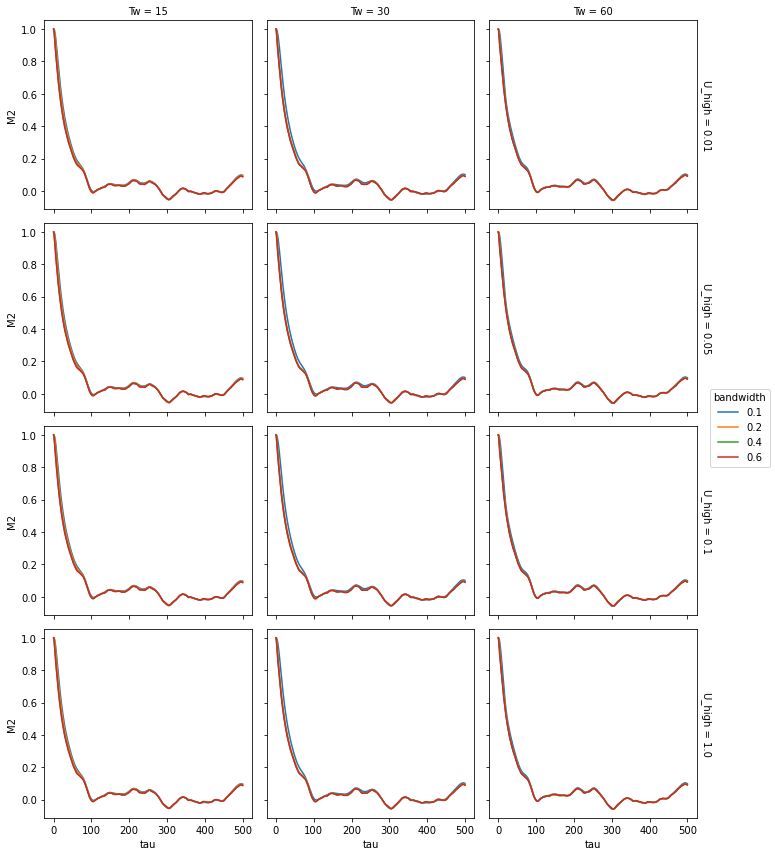

In [67]:
plt.figure()
(ds30.M2/ds30.M2.isel(tau=0)).sel(T=30,T_low=5).plot(hue='bandwidth',row='U_high',col='Tw')

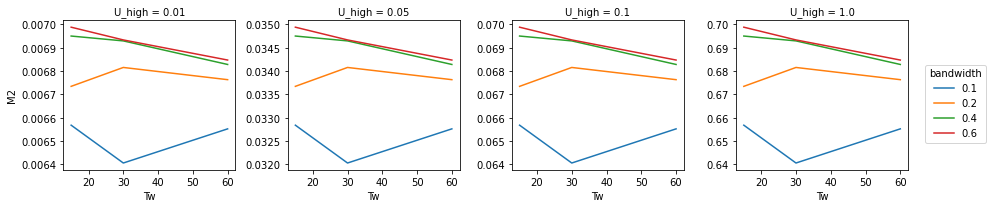

In [68]:
np.sqrt(ds30.M2.isel(tau=0).sel(T = 30,T_low=5)).plot(hue='bandwidth',col='U_high',sharey=False)

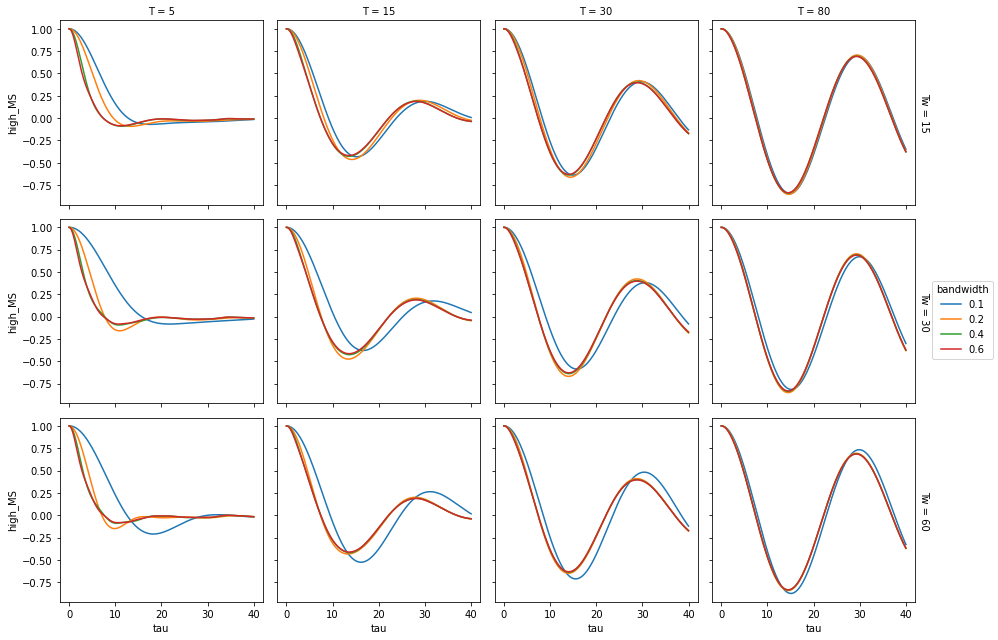

<Figure size 432x288 with 0 Axes>

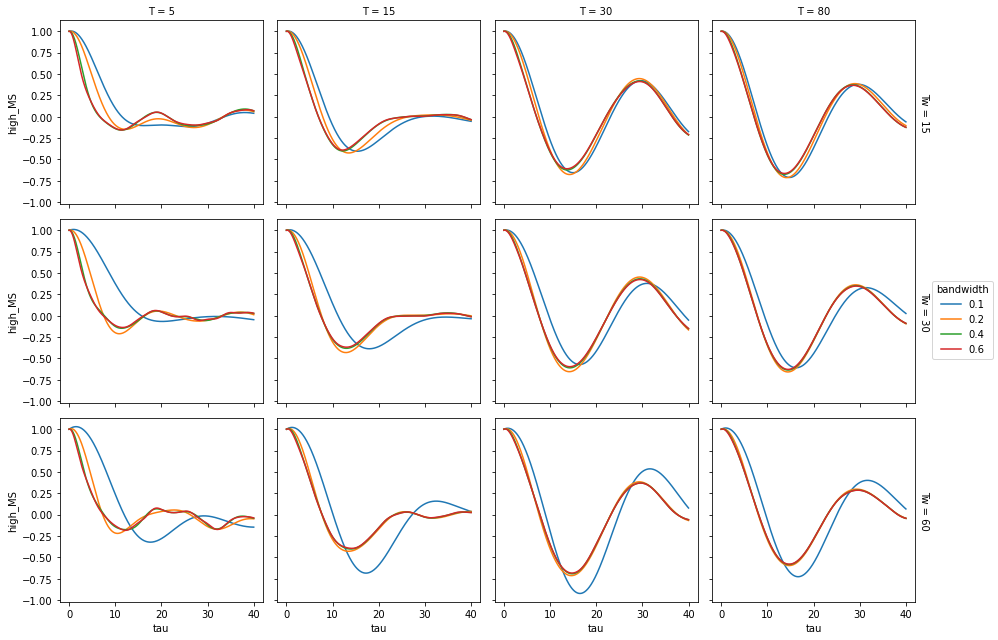

In [69]:
(ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=0.1,T_low=30).sel(tau=slice(0,40)
                                                                    ).plot(hue='bandwidth',col='T',row='Tw')
plt.figure()
(ds30_80.high_MS/ds30_80.high_MS.isel(tau=0)).sel(U_high=0.1,T_low=30).sel(tau=slice(0,40)
                                                                    ).plot(hue='bandwidth',col='T',row='Tw')

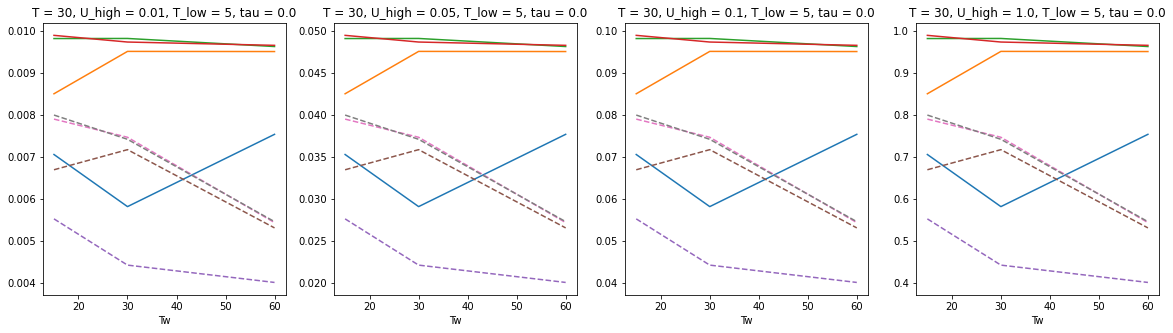

In [70]:
number = ds1.U_high.size
cmap=plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0.2, .7, number)]
fig,ax = plt.subplots(1,ds1.U_high.size,figsize=(5*ds1.U_high.size,5),sharey=False)
for i, U in enumerate(ds1.U_high):
    np.sqrt(ds30.high_MS.isel(tau=0).sel(T = 30,T_low=5,U_high=U)).plot(hue='bandwidth',ax=ax[i],
                                                                        add_legend=False)
    np.sqrt(ds30_80.high_MS.isel(tau=0).sel(T = 30,T_low=5,U_high=U)).plot(hue='bandwidth',
                                                                           linestyle='--',ax=ax[i],add_legend=False)
    ax[i].set_ylabel('')

#### Total : Variance

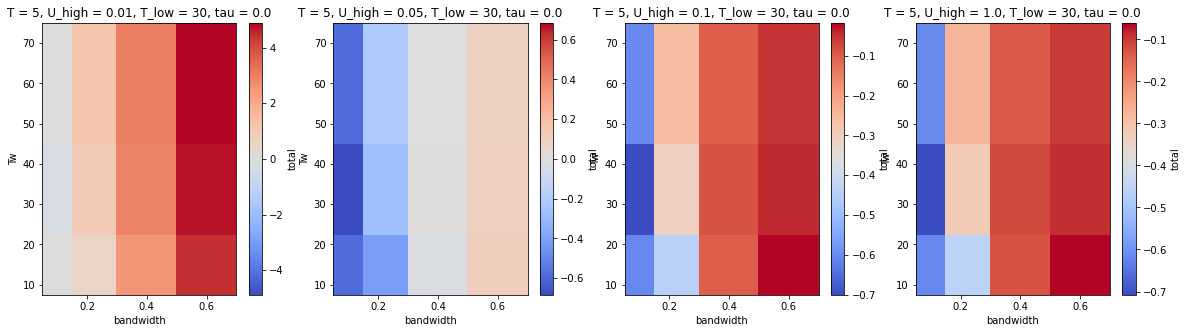

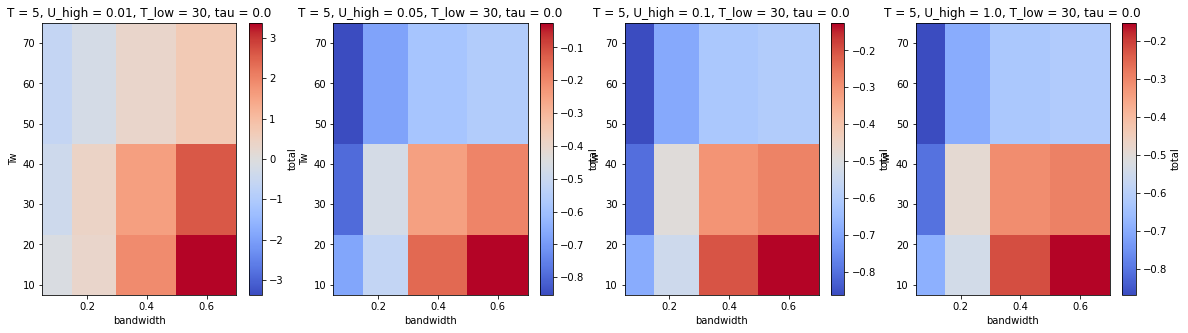

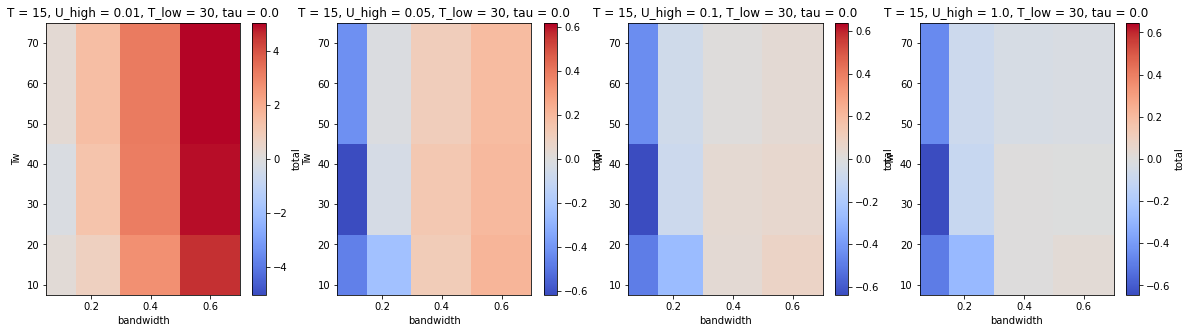

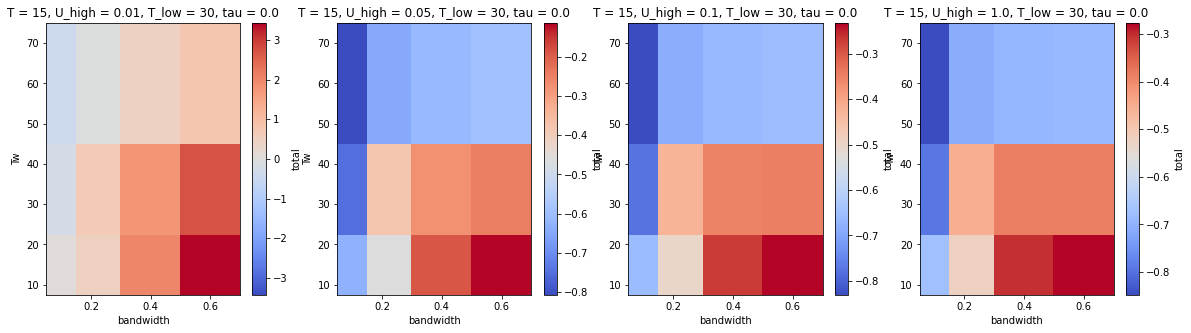

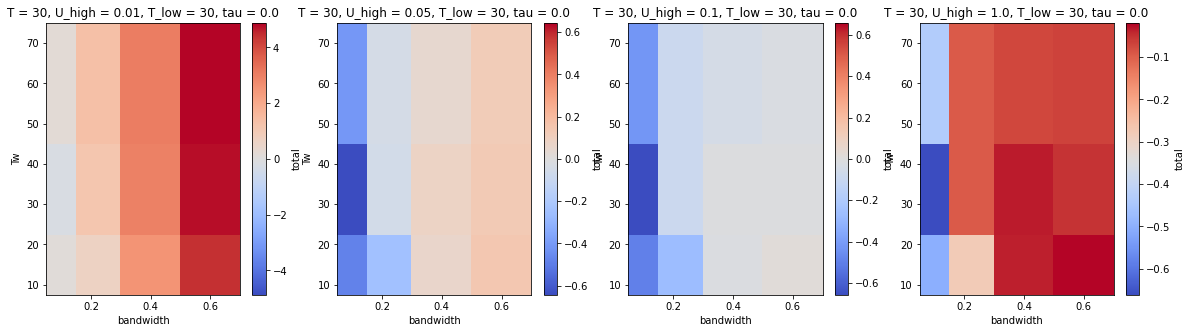

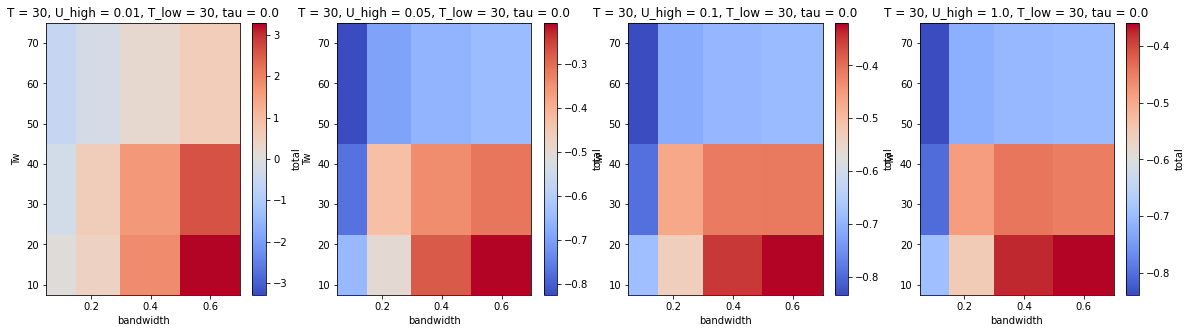

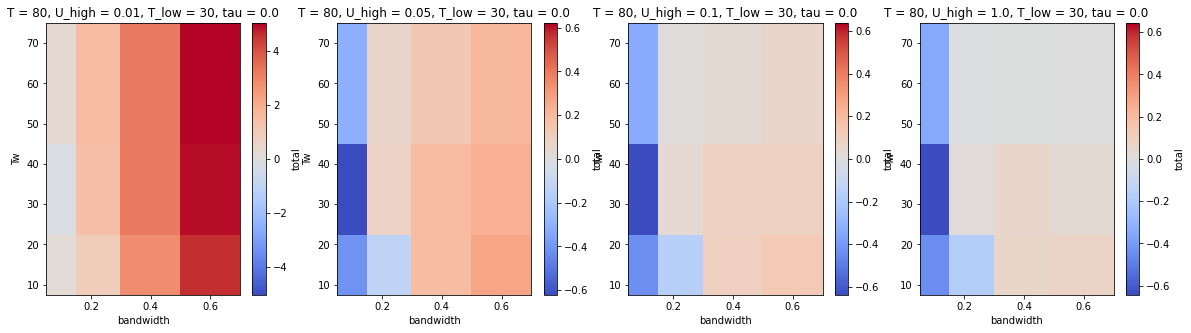

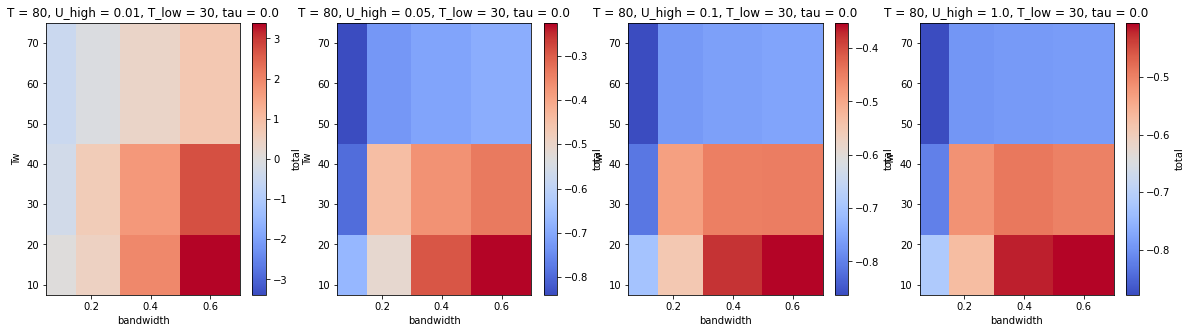

In [71]:
for t in ds30.T.values:
    fig,ax = plt.subplots(1,ds30.U_high.size,figsize=(5*ds30.U_high.size,5))
    for i,U in enumerate(ds30.U_high.values):
        (np.abs(ds30.total.isel(tau=0).sel(T_low=30,T=t,U_high=U)/U**2)-1).plot(x='bandwidth',y='Tw',ax=ax[i],cmap='coolwarm')
    fig,ax = plt.subplots(1,ds30.U_high.size,figsize=(5*ds30.U_high.size,5))
    for i,U in enumerate(ds30.U_high.values):
        (np.abs(ds30_80.total.isel(tau=0).sel(T_low=30,T=t,U_high=U)/U**2)-1).plot(x='bandwidth',y='Tw',ax=ax[i],cmap='coolwarm')
        #vmax = U/10#max(np.abs(np.sqrt(ds30.total.isel(tau=0).sel(T_low=30,T=15,U_high=U))-U).max(),U/10)
        #(np.sqrt(ds30.total.isel(tau=0).sel(T_low=30,T=t,U_high=U))-U).plot(x='bandwidth',y='Tw',ax=ax[i],cmap='coolwarm',vmax=vmax)
  

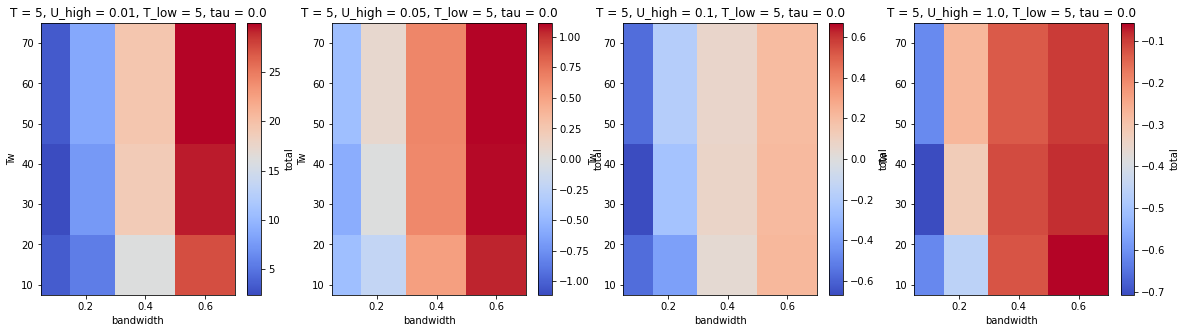

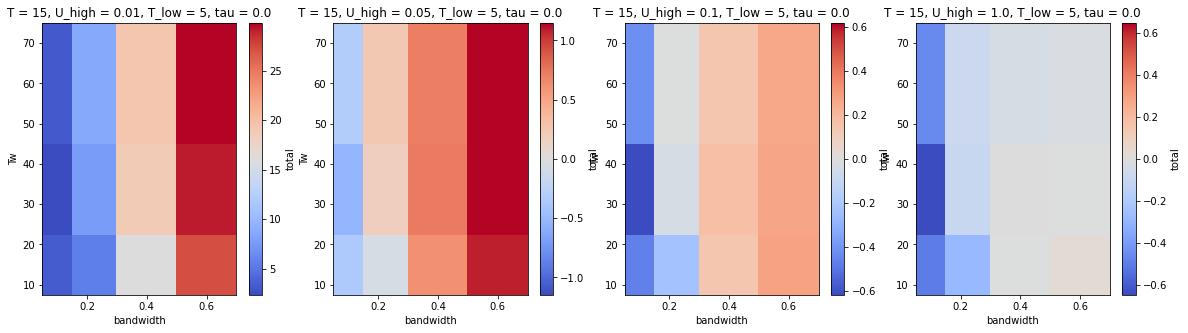

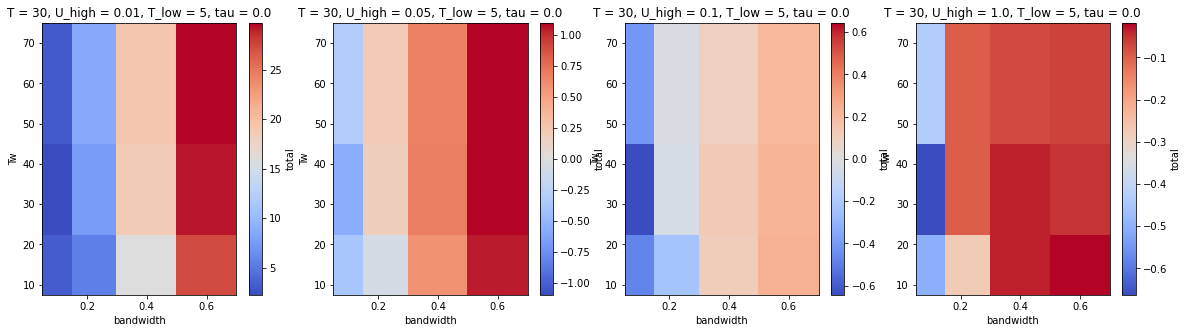

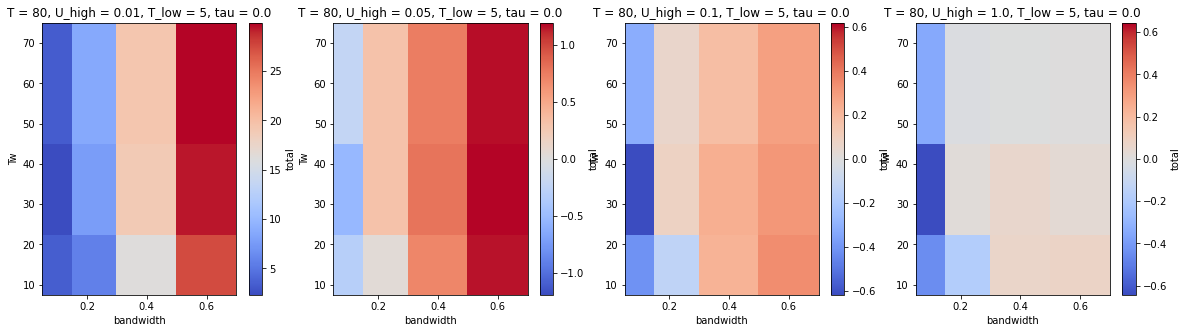

In [72]:
for t in ds30.T.values:
    fig,ax = plt.subplots(1,ds30.U_high.size,figsize=(5*ds30.U_high.size,5))
    for i,U in enumerate(ds30.U_high.values):
        (np.abs(ds30.total.isel(tau=0).sel(T_low=5,T=t,U_high=U)/U**2)-1).plot(x='bandwidth',y='Tw',ax=ax[i],cmap='coolwarm')
#        vmax = max(np.abs(np.sqrt(ds30.total.isel(tau=0).sel(T_low=5,T=15,U_high=U))-U).max(),U/10)
#        (np.sqrt(ds30.total.isel(tau=0).sel(T_low=5,T=t,U_high=U))-U).plot(x='bandwidth',y='Tw',ax=ax[i],cmap='coolwarm',vmax=vmax)

#### Total : form of autocorrelation

In [73]:
tt = time[:40*24]

In [98]:
def plot_high_total(U,band,Tw,Tl):
    fig,ax = plt.subplots(1,ds1.T.size,figsize=(5*ds1.T.size,5),sharey=True)
    for i,t in enumerate(ds1.T) :
        (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=Tl,Tw=Tw,bandwidth=band,T=t
                                             ).sel(tau=slice(0,40)).plot(ax=ax[i],label=r'Total : $\bar T$=%sd'%Tl)

        (ds1.high_MS/ds1.high_MS.isel(tau=0)).sel(U_high=U,Tw=Tw,bandwidth=band,T=t
                                                 ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',
                                                                             label='High frequency')
        ax[i].set_title('T = %s days'%t.values);ax[i].grid()
        ax[i].plot(tt,np.exp(-tt/t.values),c='k',zorder=0,label='Exponential model')
    ax[i].legend()
    fig.suptitle(r'1 draw : $\tilde V = %s, d\omega=%scpd,T_w=%sd$'%(U,band,Tw))
    fig,ax = plt.subplots(1,ds1.T.size+1,figsize=(5*(ds1.T.size+1),5),sharey=True)
    for i,t in enumerate(ds1.T) :
        (ds30.total/ds30.total.isel(tau=0)).sel(U_high=U,T_low=Tl,Tw=Tw,bandwidth=band,T=t
                                               ).sel(tau=slice(0,40)).plot(ax=ax[i],label=r'Total : $\bar T$=%sd'%Tl)
        (ds30.high_MS/ds30.high_MS.isel(tau=0)).sel(U_high=U,T_low=Tl,Tw=Tw,bandwidth=band,T=t
                                                   ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High frequency')
        (ds30_80.total/ds30_80.total.isel(tau=0)).sel(U_high=U,T_low=Tl,Tw=Tw,bandwidth=band,T=t
                                                   ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='Total : 80d')
        (ds30_80.high_MS/ds30_80.high_MS.isel(tau=0)).sel(U_high=U,T_low=Tl,Tw=Tw,bandwidth=band,T=t
                                                   ).sel(tau=slice(0,40)).plot(ax=ax[i],linestyle='--',label='High : 80d')
        ax[i].set_title('T = %s days'%t.values);ax[i].grid();
        ax[i].plot(tt,np.exp(-tt/t.values),c='k',zorder=0,label='Exponential model')
    ax[0].legend()
    (ds30_coh.total/ds30_coh.total.isel(tau=0)).sel(T=Tl,Tw=Tw,bandwidth=band
                                               ).sel(tau=slice(0,40)).plot(ax=ax[-1],label=r'Total : $\bar T$=%sd'%Tl)
    (ds30_coh.high/ds30_coh.high.isel(tau=0)
    ).sel(Tw=Tw,bandwidth=band).sel(tau=slice(0,40)).plot(ax=ax[-1],
                                                          linestyle='--',label='High frequency')
    ax[-1].grid();ax[-1].set_title('Coherent')
    fig.suptitle(r'30 draws : $\tilde V = %s, d\omega=%scpd,T_w=%sd$'%(U,band,Tw))

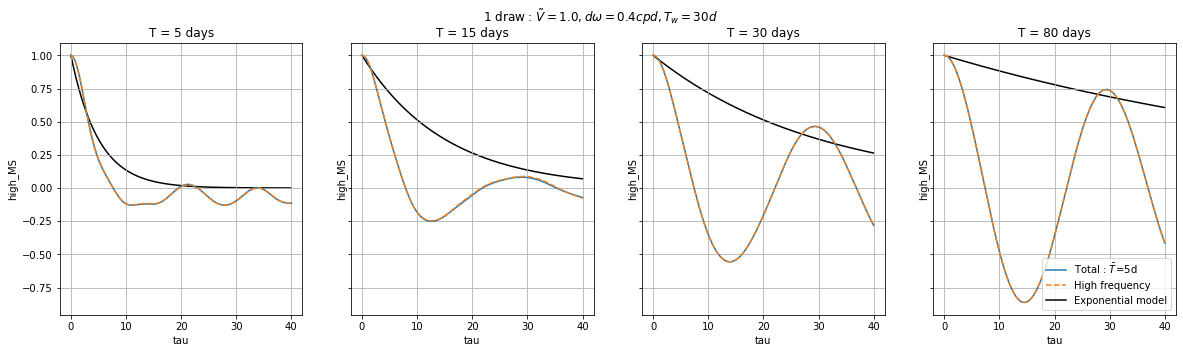

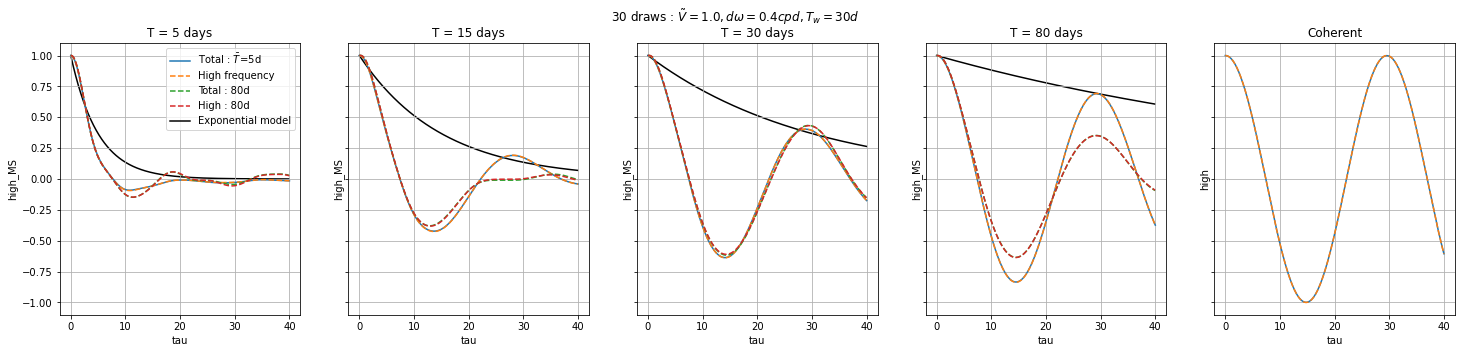

In [99]:
plot_high_total(1.,0.4,30,5)

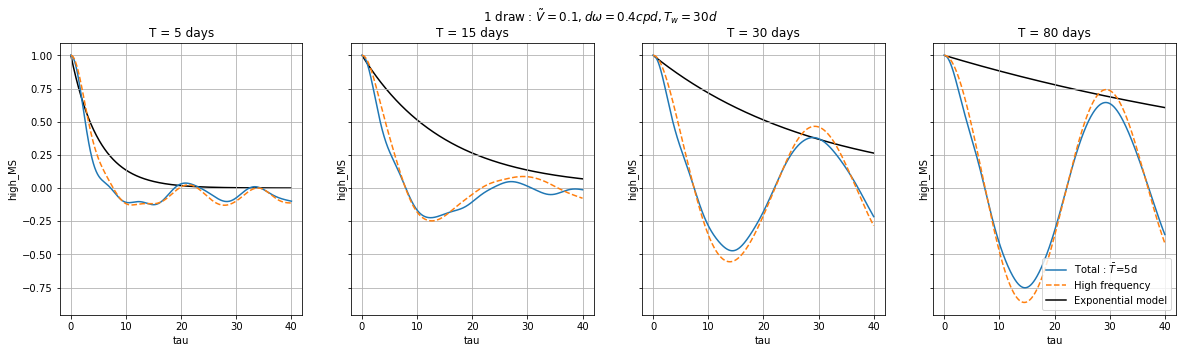

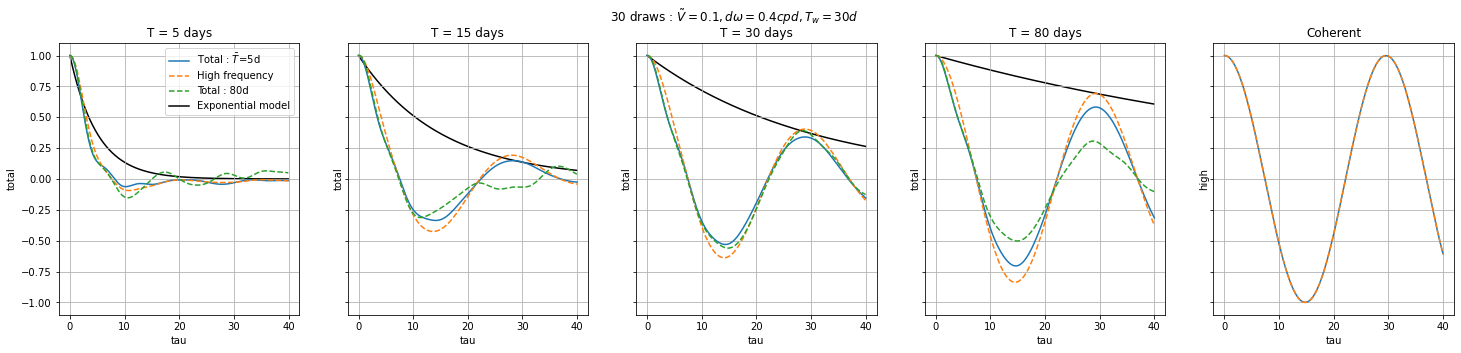

In [93]:
plot_high_total(.1,0.4,30,5)

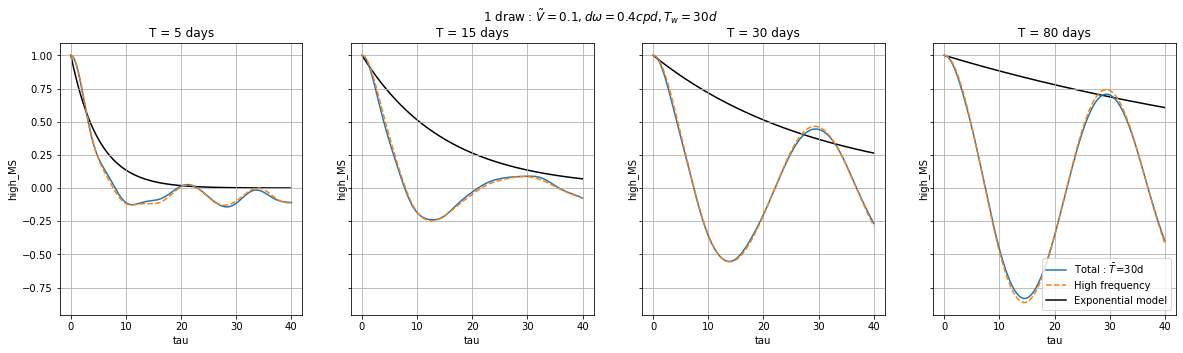

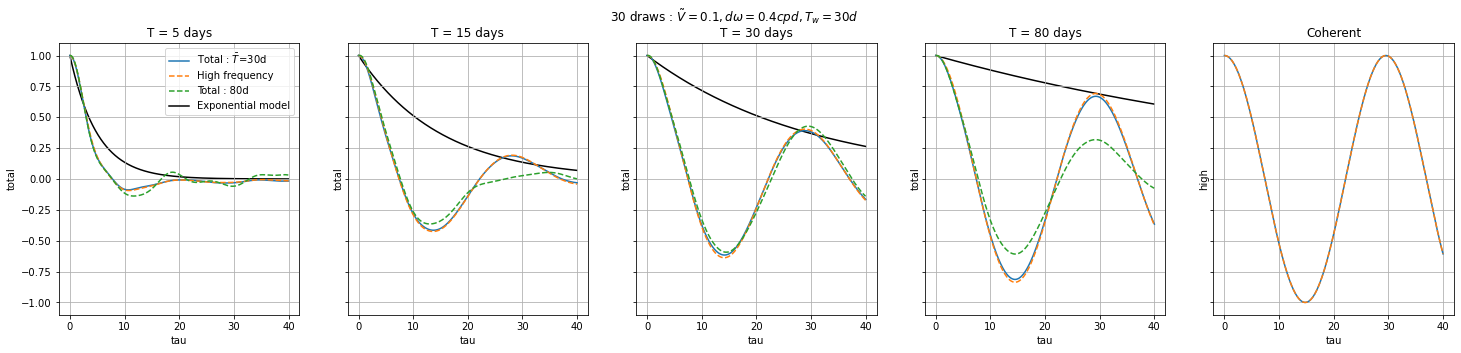

In [94]:
plot_high_total(.1,0.4,30,30)

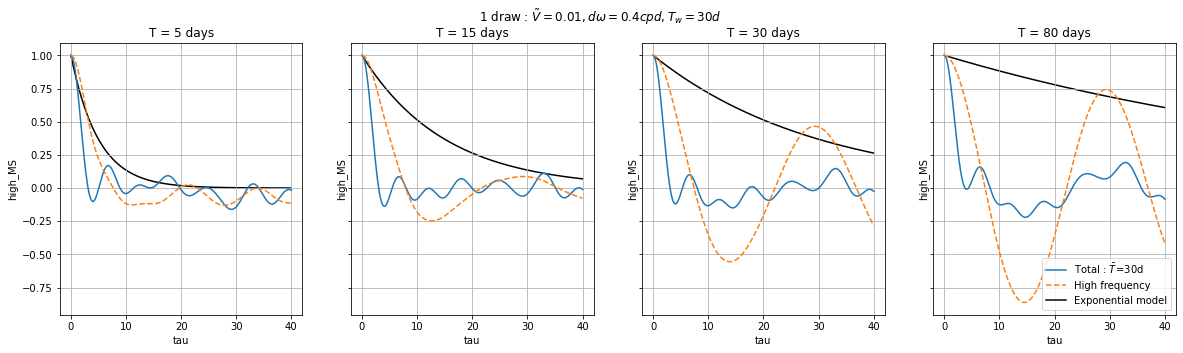

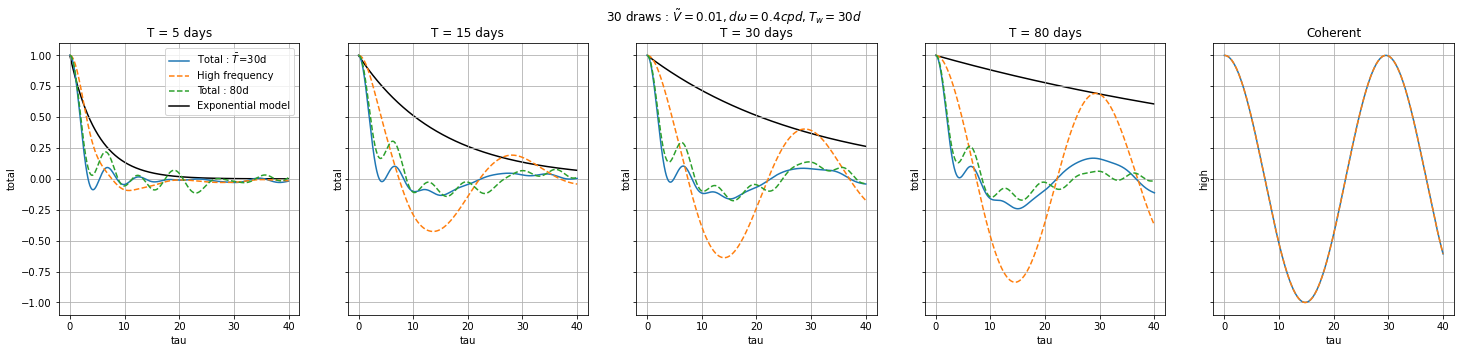

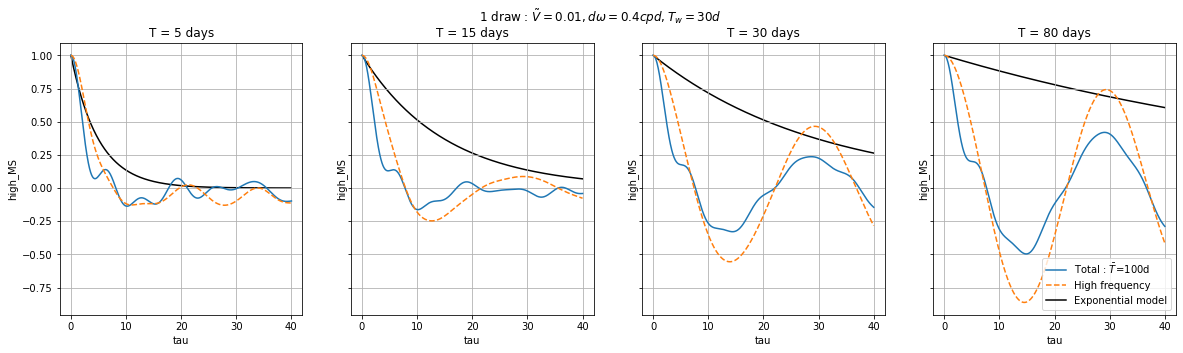

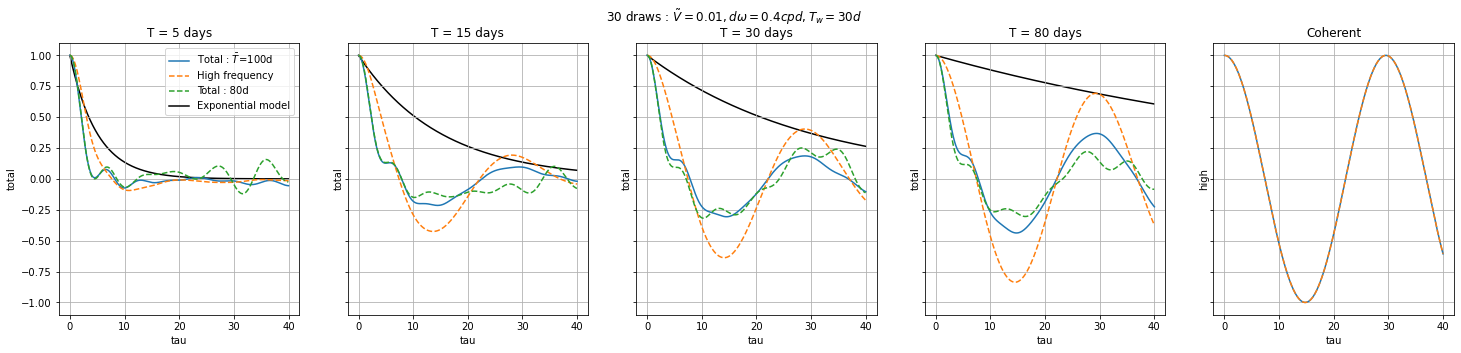

In [95]:
plot_high_total(.01,0.4,30,30)

plot_high_total(.01,0.4,30,100)

#### Estimation timescales:

In [52]:
tf=20
T1_high = ((ds1.high_MS/ds1.high_MS.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
T30_high = ((ds30.high_MS/ds30.high_MS.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')

#T1_high_NK = ((ds1.high_MSNK/ds1.high_MSNK.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
#T30_high_NK = ((ds30.high_MSNK/ds30.high_MSNK.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
#T78_high  = ((ds78.high_MS/ds78.high.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')


T1 = ((ds1.total/ds1.total.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
T30 = ((ds30.total/ds30.total.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
#T78  = ((ds78.total/ds78.total.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')

In [53]:
Tt_high = xr.Dataset({'T1':T1_high,'T30':T30_high})#,'T78':T78_high})
#Tt_high_NK = xr.Dataset({'T1':T1_high_NK,'T30':T30_high_NK})#,'T78':T78_high})
Tt = xr.Dataset({'T1':T1,'T30':T30})#,'T78':T78})

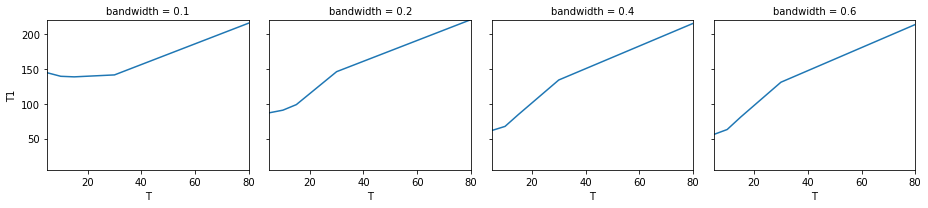

<Figure size 432x288 with 0 Axes>

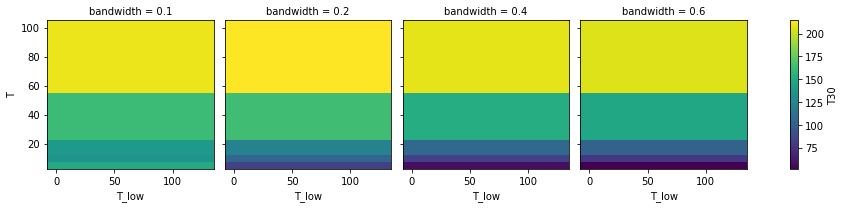

In [54]:
Tt_high.T1.sel(U_high=1.,Tw=30).plot(col='bandwidth',xlim=(5,80),ylim=(5,None))
plt.figure()
Tt_high.T30.sel(U_high=1.,Tw=30).plot(col='bandwidth')
#plt.figure()
#Tt_high.T78.sel(U_high=1.,Tw=30).plot(col='bandwidth')

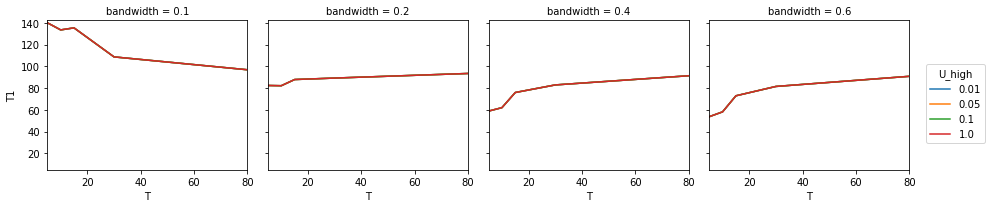

<Figure size 432x288 with 0 Axes>

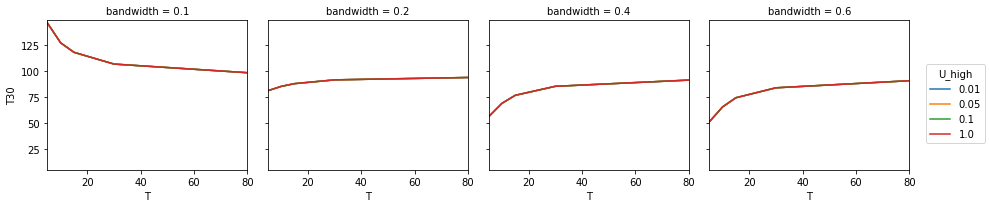

In [51]:
Tt_high.T1.sel(Tw=30).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None))
plt.figure()
Tt_high.T30.sel(Tw=30,T_low=30).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None))
#plt.figure()
#Tt_high.T78.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None))

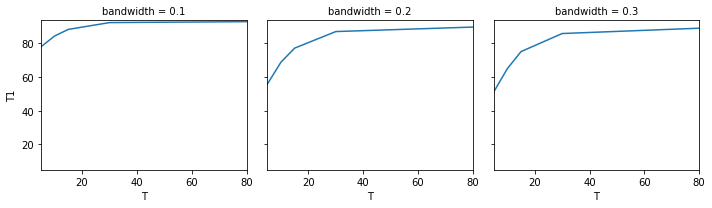

<Figure size 432x288 with 0 Axes>

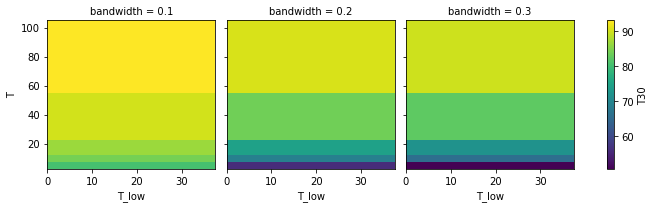

In [32]:
Tt_high.T1.sel(U_high=1.,Tw=30).plot(col='bandwidth',xlim=(5,80),ylim=(5,None))
plt.figure()
Tt_high.T30.sel(U_high=1.,Tw=30).plot(col='bandwidth')
#plt.figure()
#Tt_high.T78.sel(U_high=1.,Tw=30).plot(col='bandwidth')

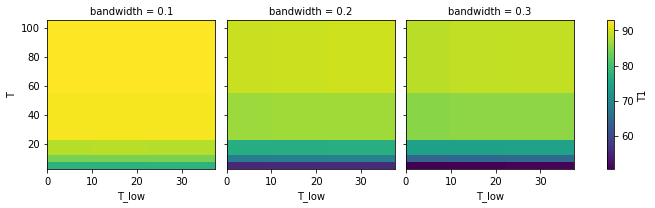

<Figure size 432x288 with 0 Axes>

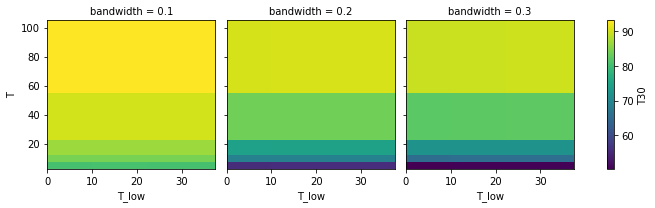

In [33]:
Tt.T1.sel(U_high=1.,Tw=30).plot(col='bandwidth')
plt.figure()
Tt.T30.sel(U_high=1.,Tw=30).plot(col='bandwidth')
#plt.figure()
#Tt.T78.sel(U_high=1.,Tw=30).plot(col='bandwidth')

Notes : 

ça marche très très peu...

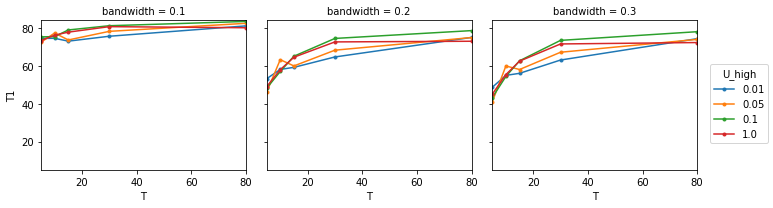

<Figure size 432x288 with 0 Axes>

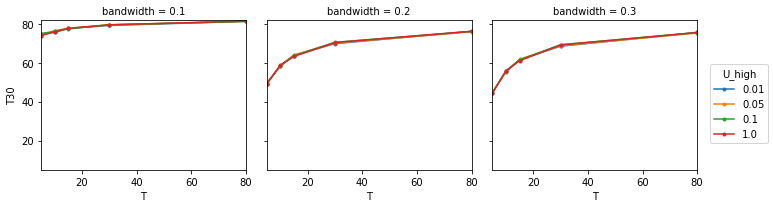

In [38]:
Tt_high_NK.T1.sel(Tw=30).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None),marker='.')
plt.figure()
Tt_high_NK.T30.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None),marker='.')

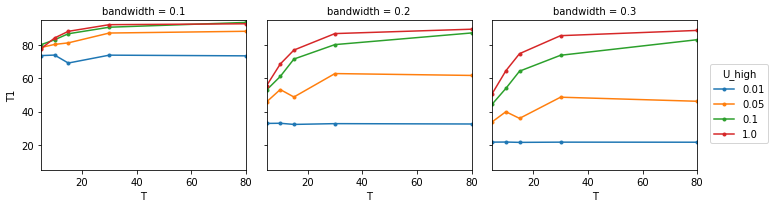

<Figure size 432x288 with 0 Axes>

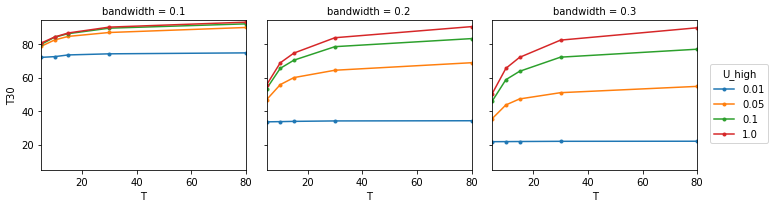

In [34]:
Tt.T1.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None),marker='.')
plt.figure()
Tt.T30.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None),marker='.')
#plt.figure()
#Tt.T78.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None),marker='.')

### Total signal : 

<Figure size 432x288 with 0 Axes>

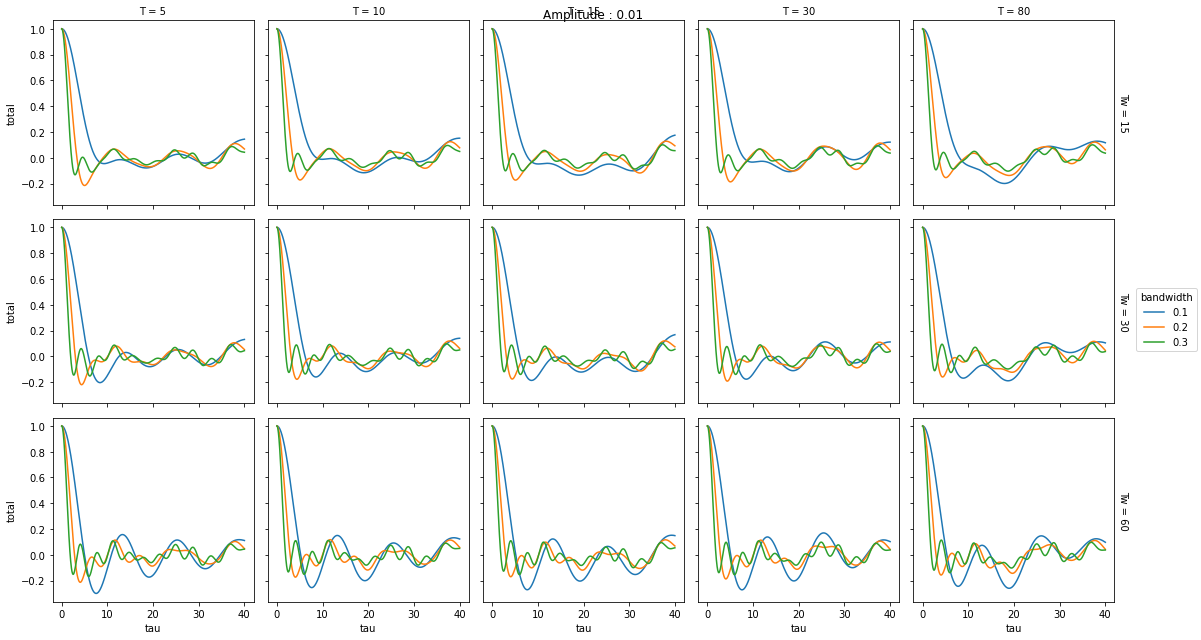

<Figure size 432x288 with 0 Axes>

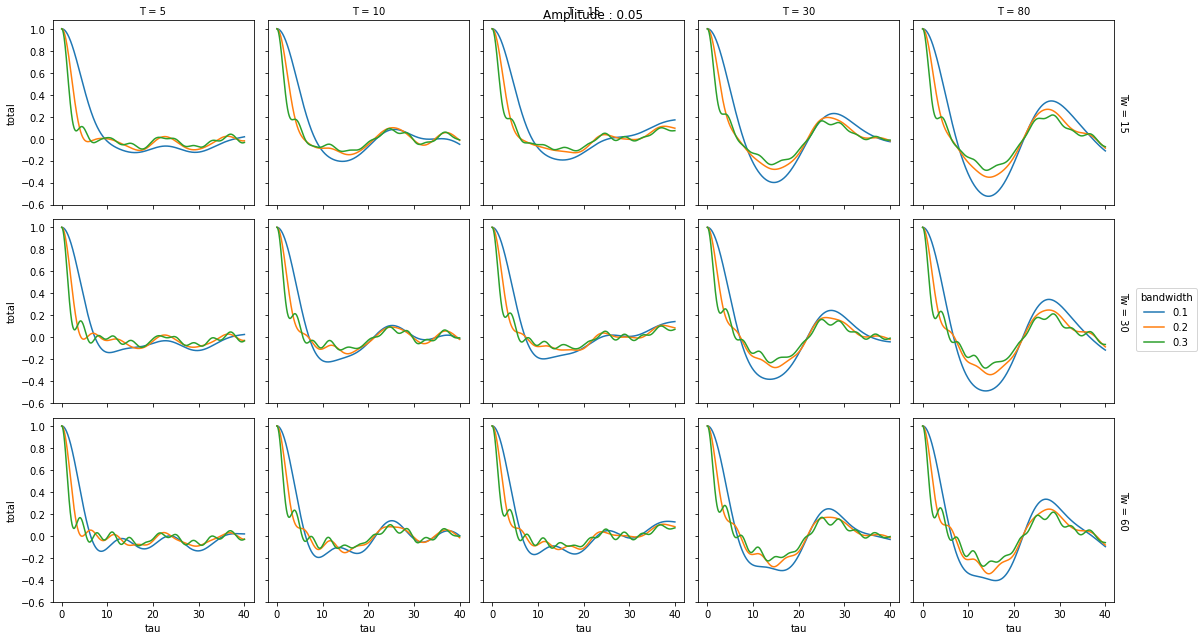

<Figure size 432x288 with 0 Axes>

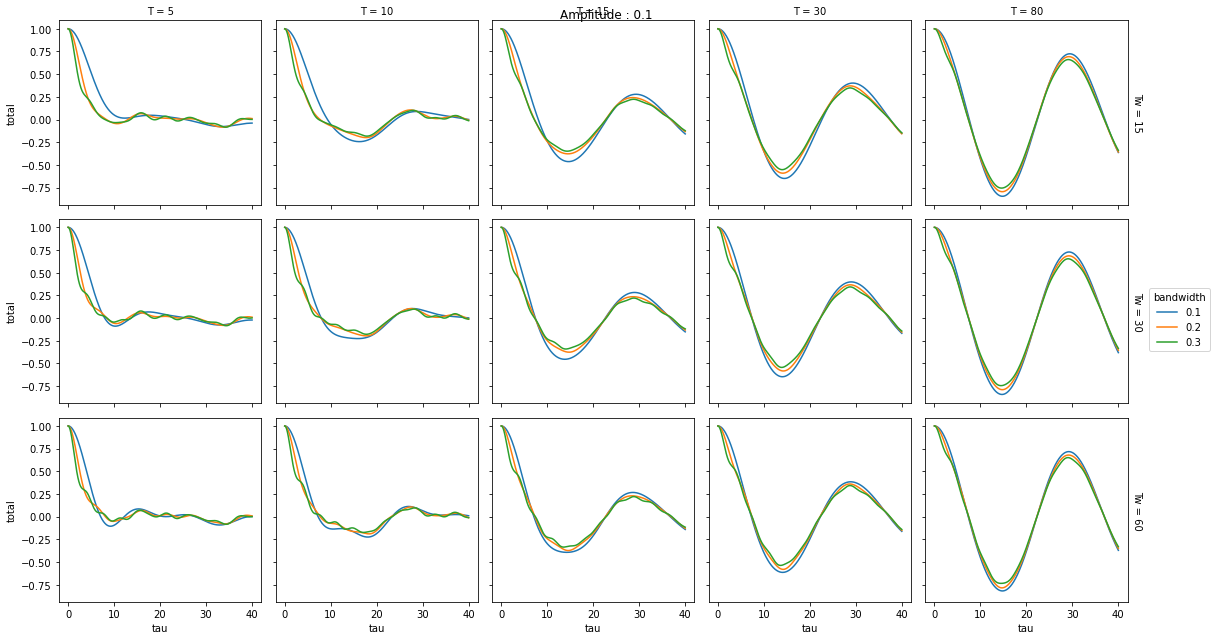

<Figure size 432x288 with 0 Axes>

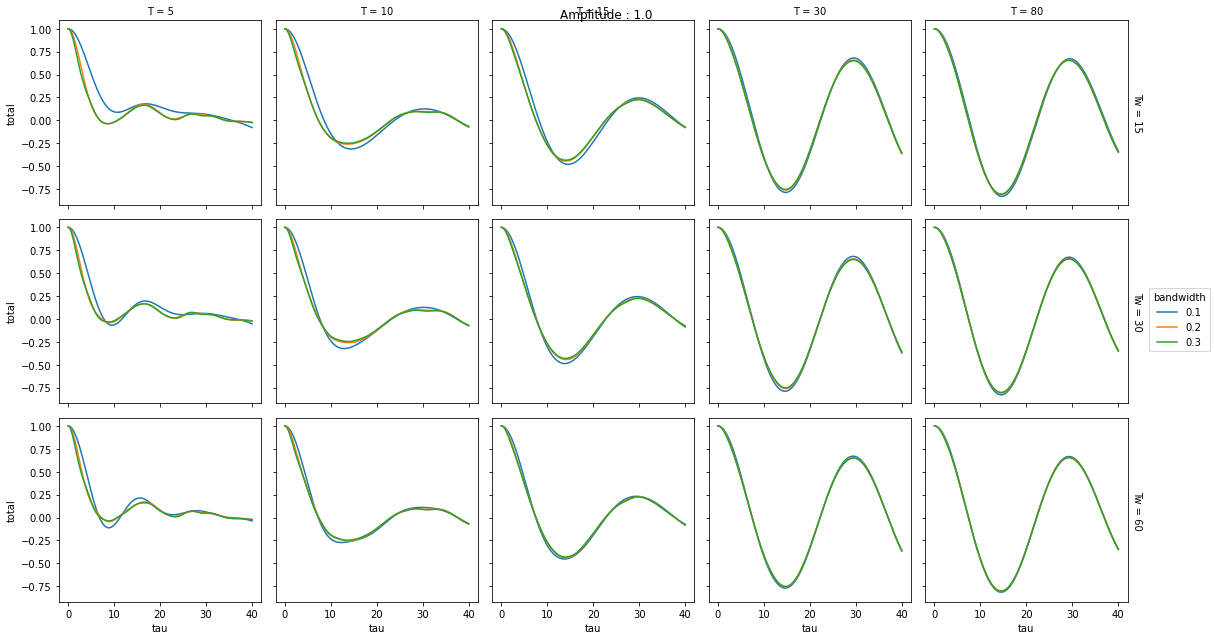

In [64]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

<Figure size 432x288 with 0 Axes>

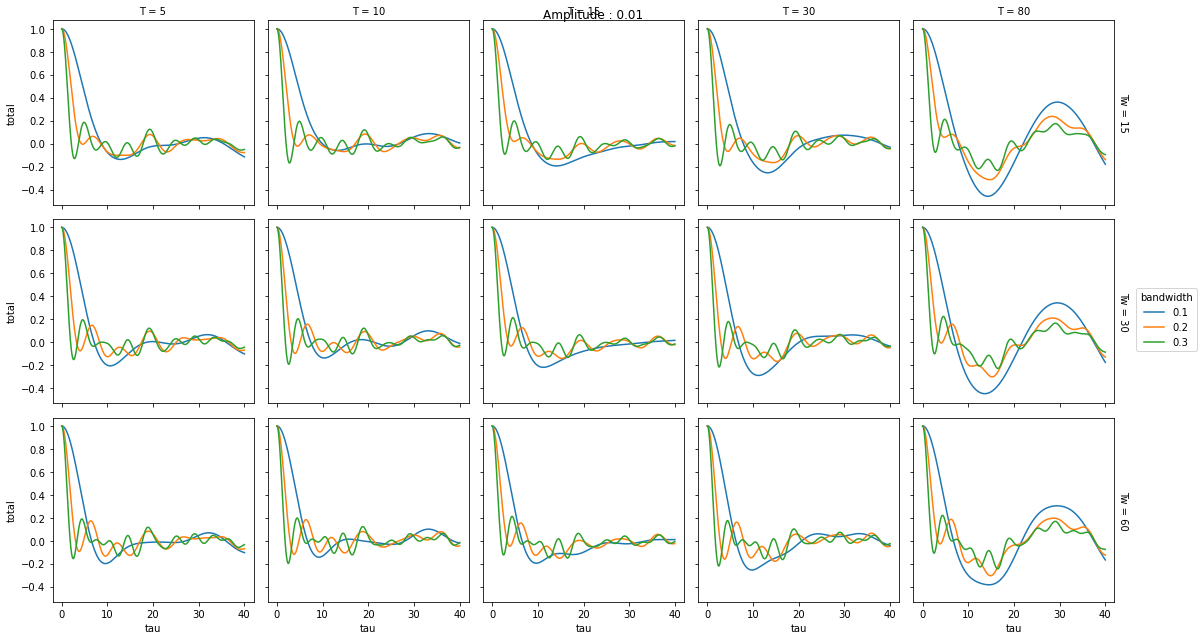

<Figure size 432x288 with 0 Axes>

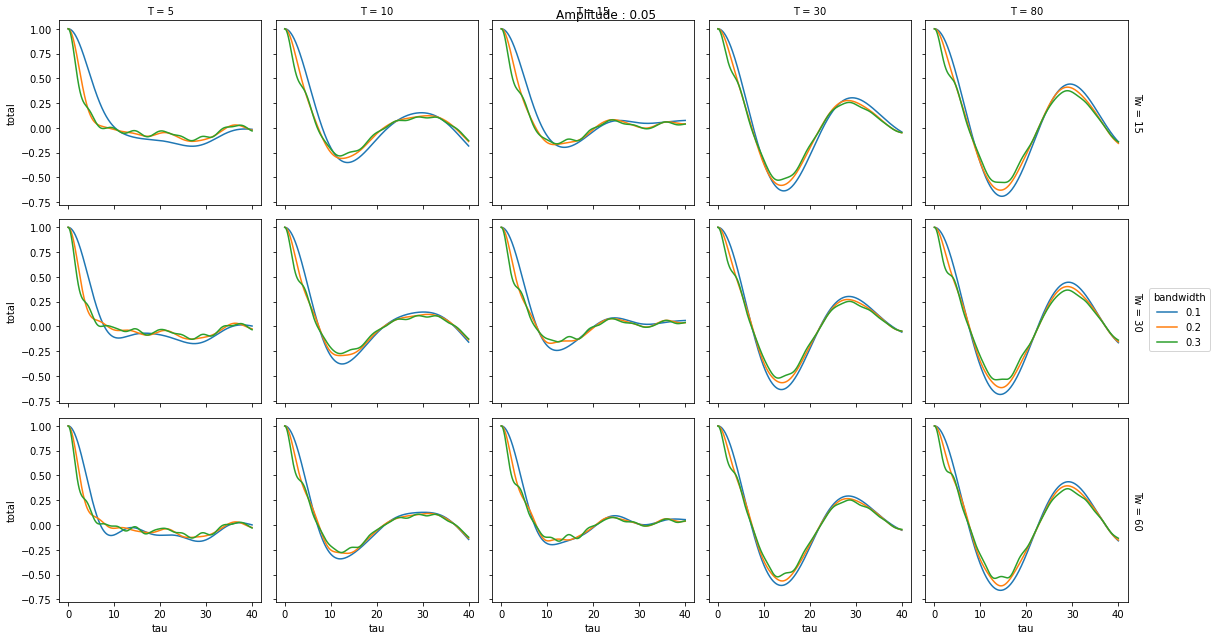

<Figure size 432x288 with 0 Axes>

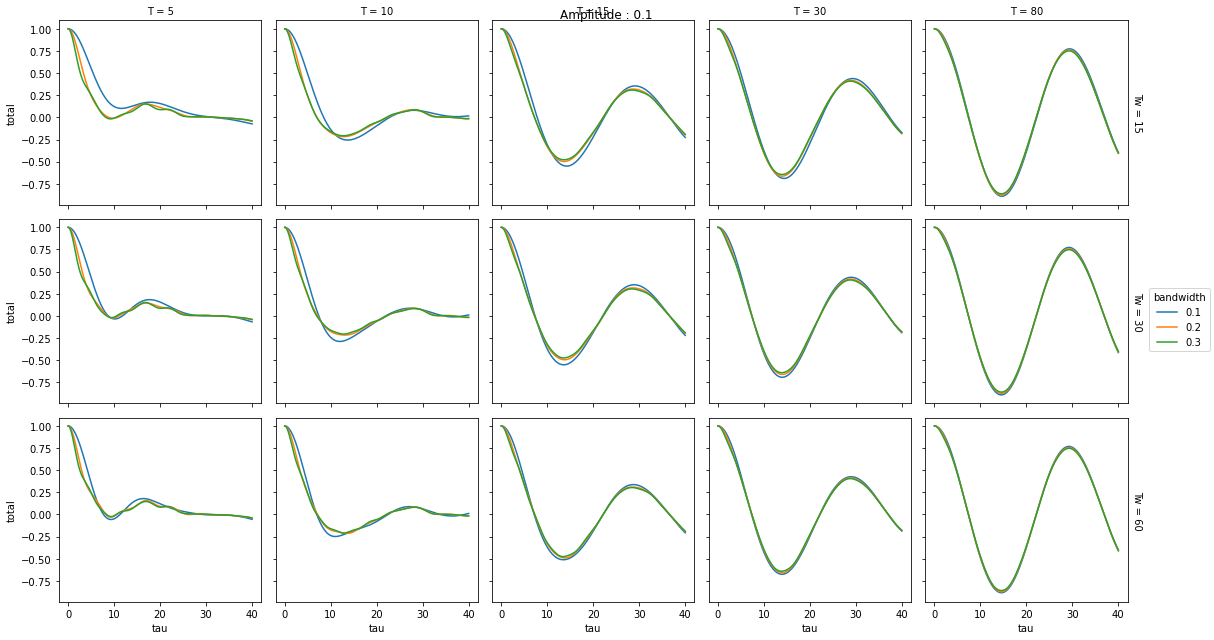

<Figure size 432x288 with 0 Axes>

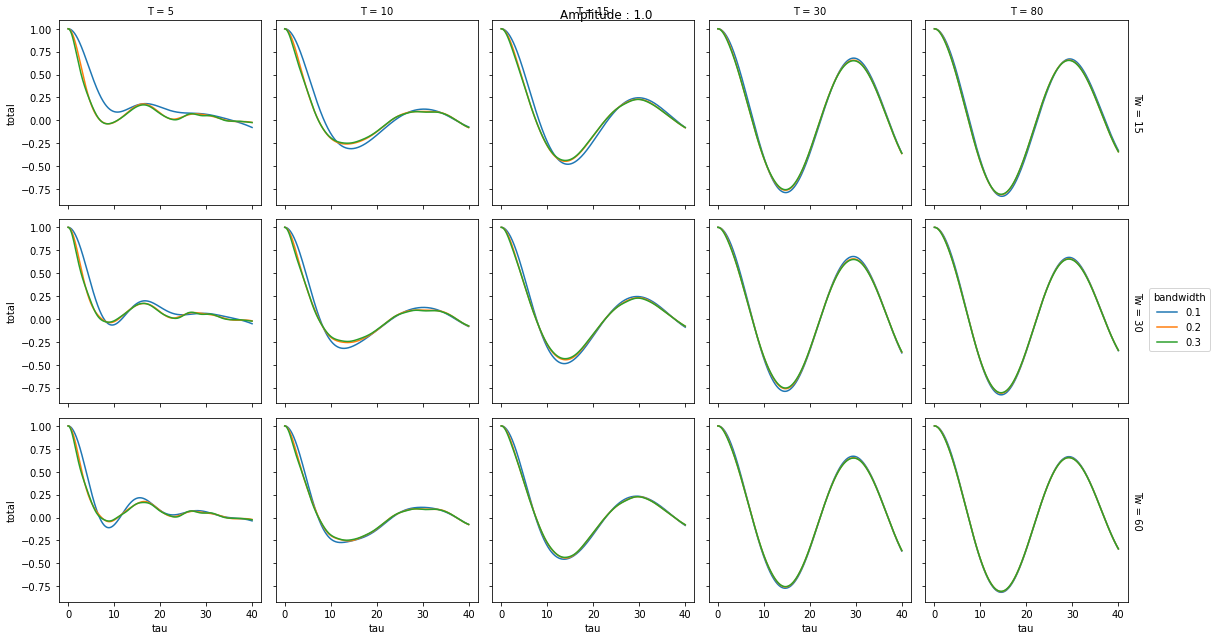

In [65]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=30).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

<Figure size 432x288 with 0 Axes>

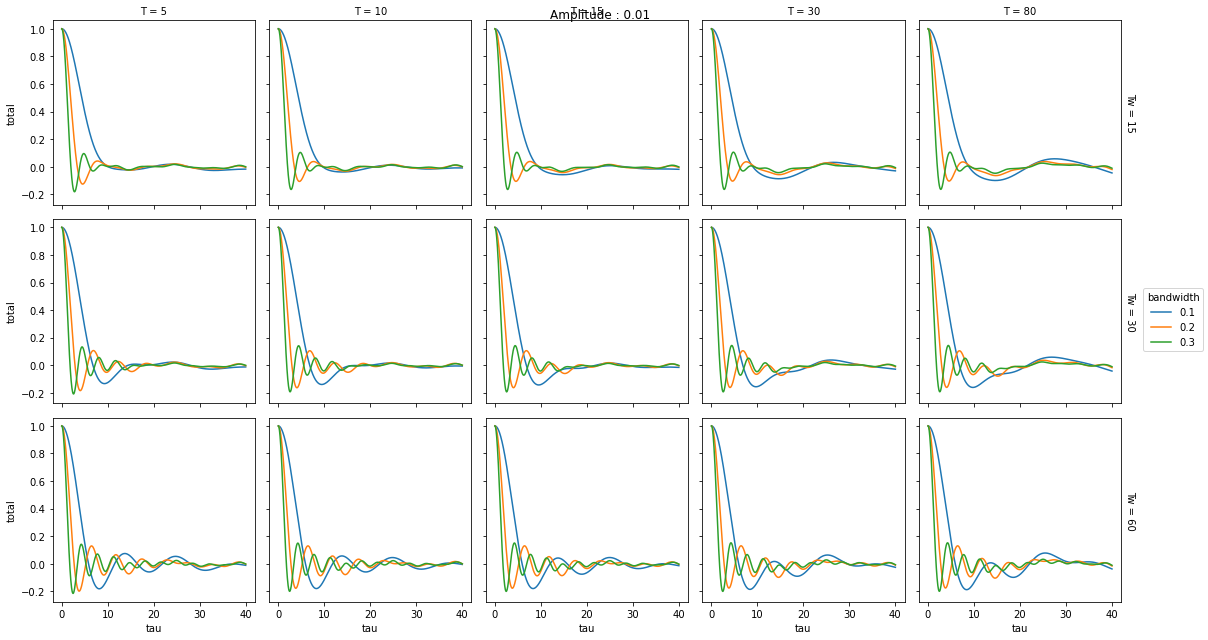

<Figure size 432x288 with 0 Axes>

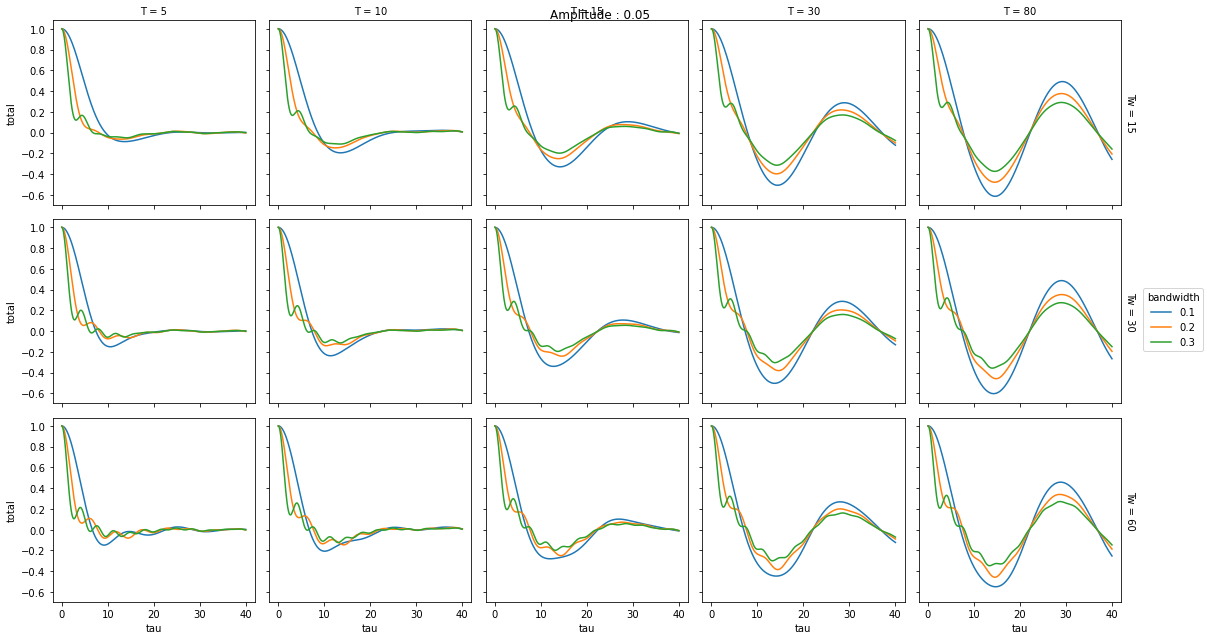

<Figure size 432x288 with 0 Axes>

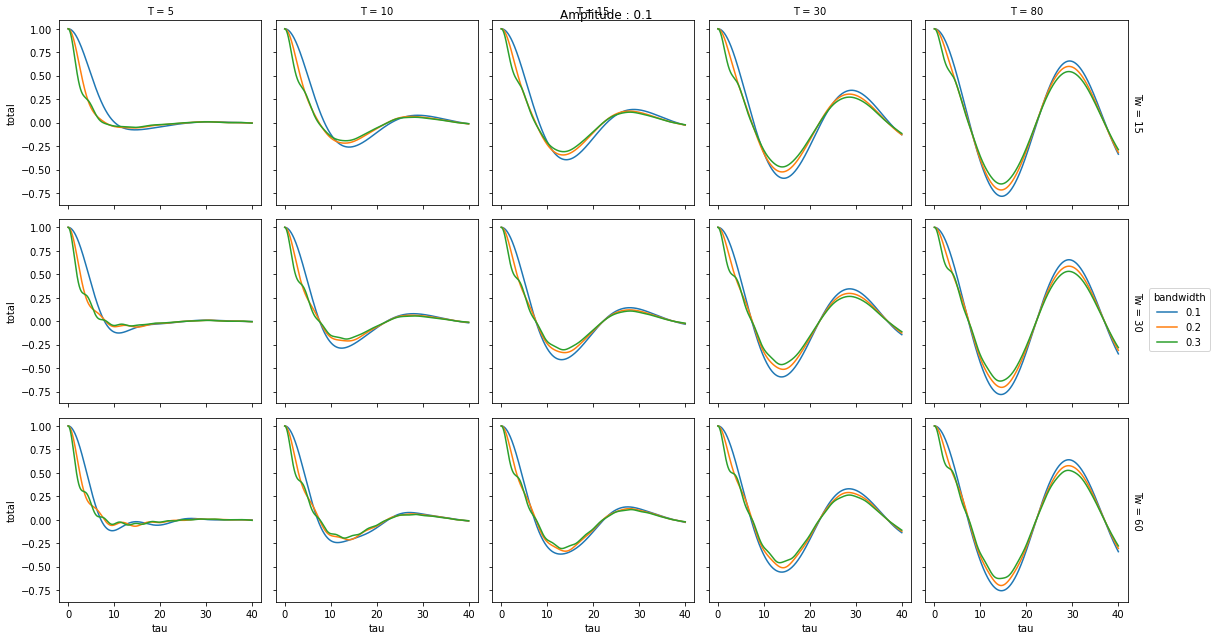

<Figure size 432x288 with 0 Axes>

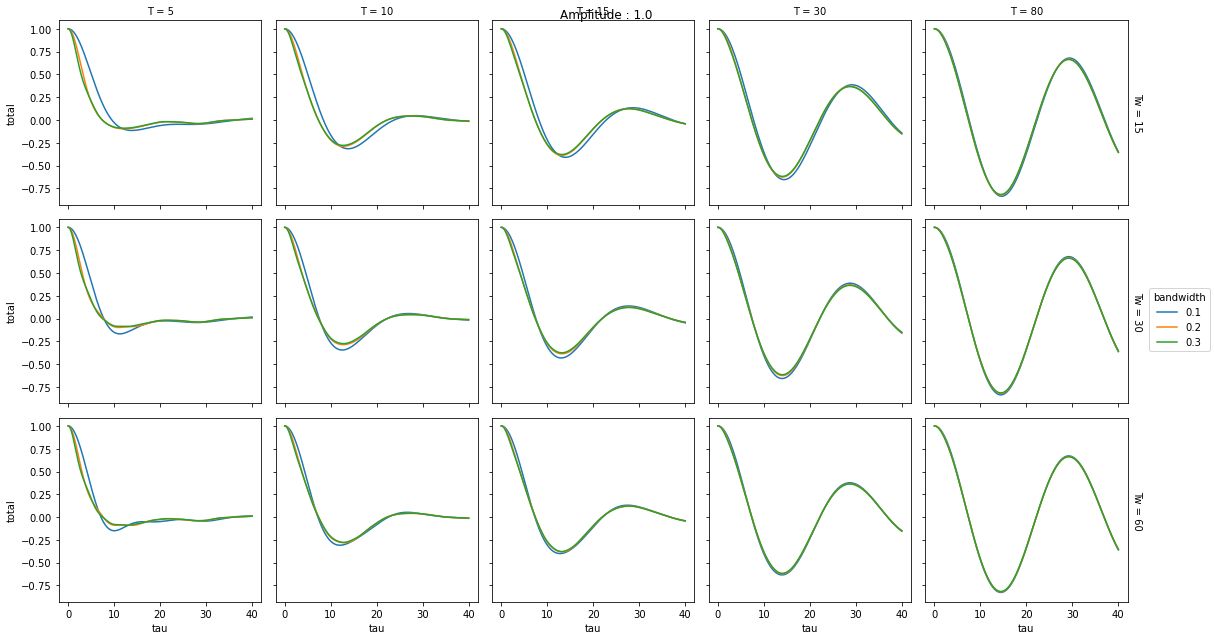

In [20]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=U,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

<Figure size 432x288 with 0 Axes>

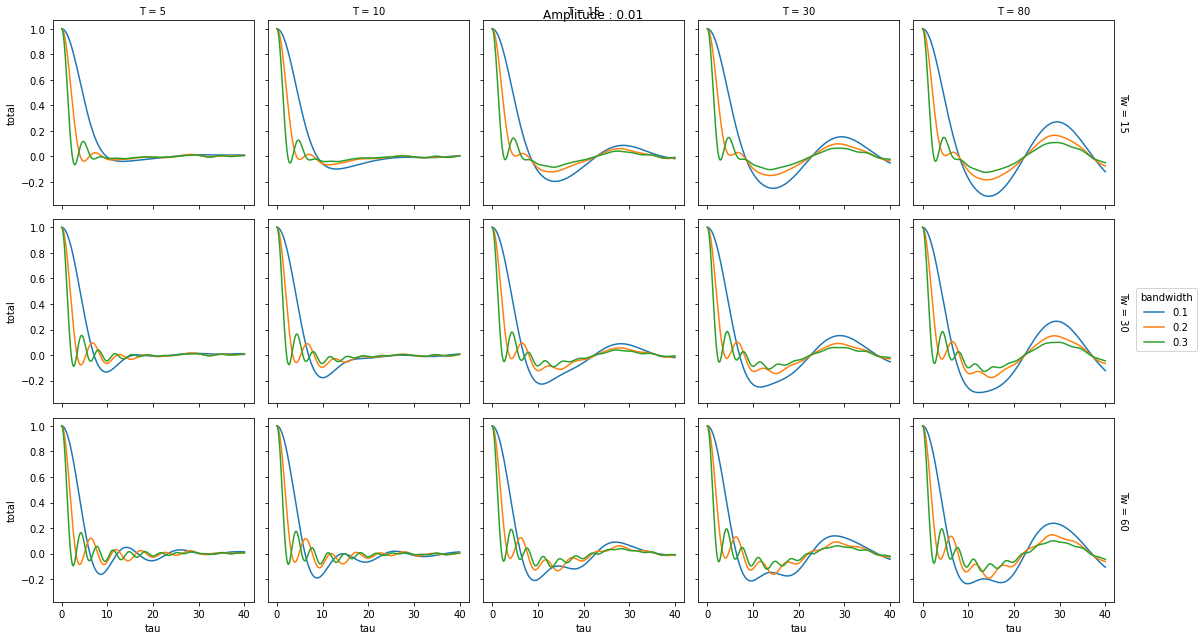

<Figure size 432x288 with 0 Axes>

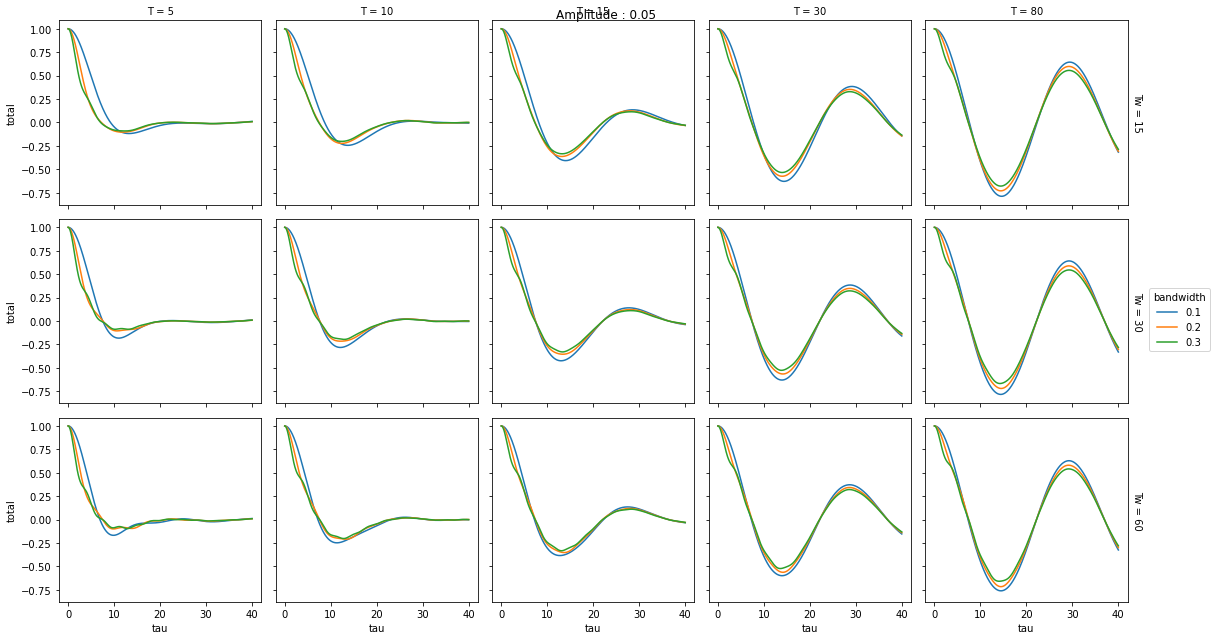

<Figure size 432x288 with 0 Axes>

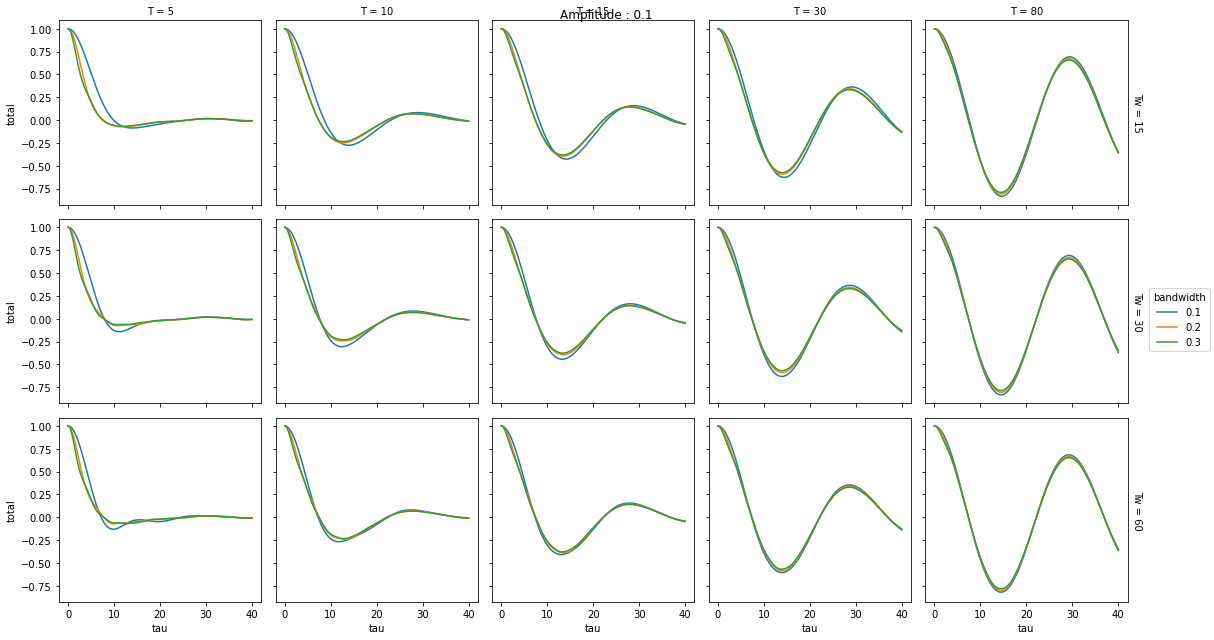

<Figure size 432x288 with 0 Axes>

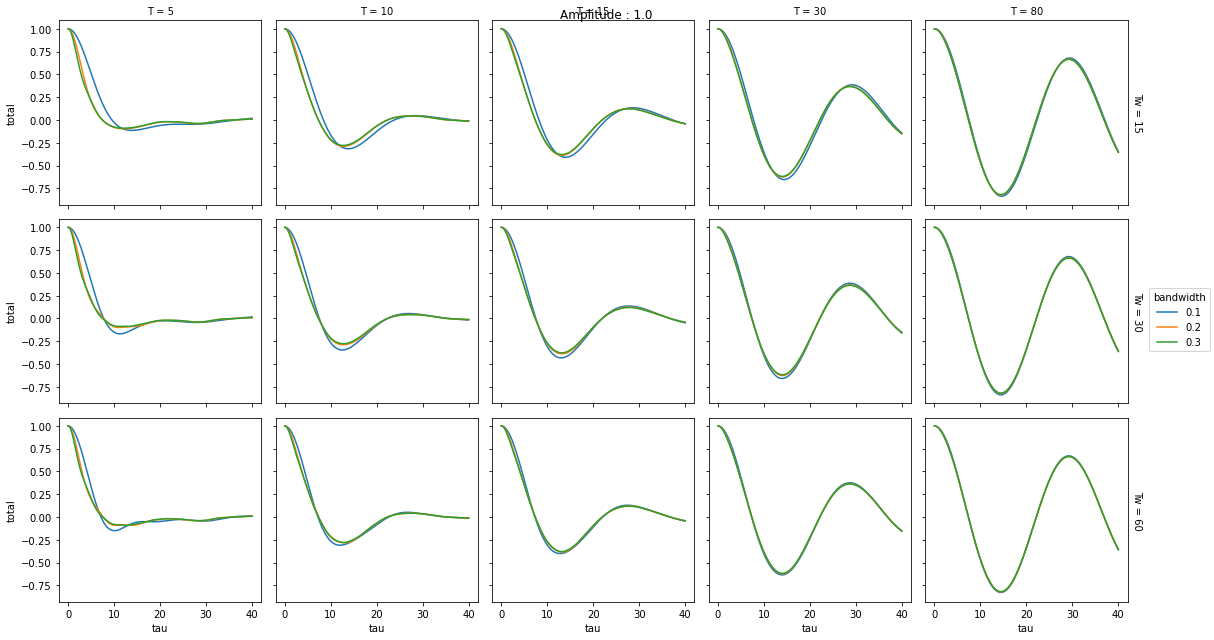

In [21]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=U,T_low=30).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

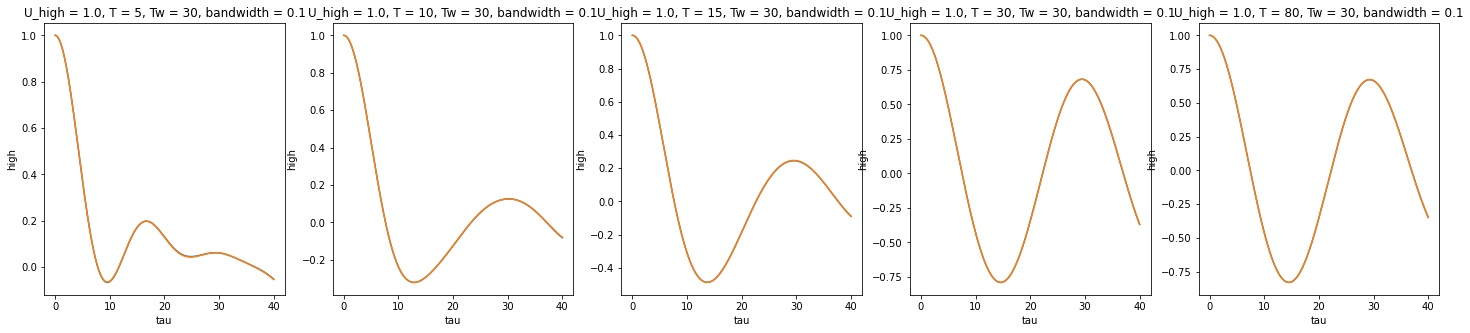

In [32]:
fig,ax = plt.subplots(1,5,figsize=(25,5))
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=30,Tw=30,bandwidth=0.1,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])
    (ds1.high/ds1.high.isel(tau=0)).sel(U_high=U,Tw=30,bandwidth=0.1,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])